# Recruit Restaurant Visitor Forecasting
## Background Story
- Restaurants need to know how many customers to expect each day to effectively purchase ingredients and schedule staff members.   
- This forecast isn't easy to make because many unpredictable factors affect restaurant attendance, like weather and local competition. It's even harder for newer restaurants with little historical data.


## About the Dataset
- 8 files of relational data is provided from two separate Japanes websites: "Hot Pepper Gourmet (hpg)" similar to Yelp and "AirREGI/Restairamt Board (air)" similar to Square, based on the time range of Jan 2016 - most of Apr 2017
- This restaurant data is from Japanese restaurants: we need to consider Japan's holdiay week called the "Golden Week".

## Goal
- Use reservation and visitation data to predict the total number of visitors to a restaurant for future dates. (-> This is a Time Series Forecasting problem)

## Evaluation
- RMSLE (root mean squared logarithmic error)

## Submission
- For every store and date combination in the test set, submission files should contain two columns: `id` and `visitors`.


In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


# EDA(Exploratory Data Analysis)

In [50]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [52]:
# 한글폰트 깨짐 해결
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

plt.rc('font', family='NanumBarunGothic')  # 나눔바른고딕 폰트 설정

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
0 upgraded, 0 newly installed, 0 to remove and 40 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent cache directory
/root/.fontconfig: not cleaning non-existent cache directory
fc-cache: succeeded


In [53]:
# 데이터를 dictionary 형태로 한번에 불러 올 수 있다.

data = {
    'tra':
    pd.read_csv('/content/gdrive/MyDrive/Aiffel/HAC/01/data/air_visit_data.csv'),
    'as':
    pd.read_csv('/content/gdrive/MyDrive/Aiffel/HAC/01/data/air_store_info.csv'),
    'hs':
    pd.read_csv('/content/gdrive/MyDrive/Aiffel/HAC/01/data/hpg_store_info.csv'),
    'ar':
    pd.read_csv('/content/gdrive/MyDrive/Aiffel/HAC/01/data/air_reserve.csv'),
    'hr':
    pd.read_csv('/content/gdrive/MyDrive/Aiffel/HAC/01/data/hpg_reserve.csv'),
    'id':
    pd.read_csv('/content/gdrive/MyDrive/Aiffel/HAC/01/data/store_id_relation.csv'),
    'tes':
    pd.read_csv('/content/gdrive/MyDrive/Aiffel/HAC/01/data/sample_submission.csv'),
    'hol':
    pd.read_csv('/content/gdrive/MyDrive/Aiffel/HAC/01/data/date_info.csv').rename(columns={
        'calendar_date': 'visit_date'
    })
}

# data_backup = copy.deepcopy(data)

참고자료 : https://www.kaggle.com/tunguz/surprise-me-2

## 일본의 공휴일
- 연간 공휴일은 16일이며 4월 말 ~ 5월 초 공휴일이 집중되어 있는 골든 위크 기간이 있는 것이 특징이다.
- __4월 29일(쇼와의 날)부터 5월 3일(헌법 기념일), 5월 4일(녹색의 날), 5월 5일(어린이날), 5월 6일 (대체 휴무일)__까지 연휴가 이어지는 주간을 __골든 위크__ 라고 부른다. 이 기간에는 회사 사정에 따라 8~10일간 쉴 수 있도록 하는 일본 최대의 연휴이다.

## Data Overview
- 제공된 데이터셋의 shape, describe, info 등을 활용해 개괄적인 정보를 확인한다.

### air_visit_data

In [54]:
print(data['tra'].shape)
data['tra'].head()

(252108, 3)


air_store_id  visit_date  visitors
0  air_ba937bf13d40fb24  2016-01-13        25
1  air_ba937bf13d40fb24  2016-01-14        32
2  air_ba937bf13d40fb24  2016-01-15        29
3  air_ba937bf13d40fb24  2016-01-16        22
4  air_ba937bf13d40fb24  2016-01-18         6

In [55]:
data['tra'].describe(include='object')

air_store_id  visit_date
count                 252108      252108
unique                   829         478
top     air_5c817ef28f236bdf  2017-03-17
freq                     477         799

레스토랑의 개수는 총 829개 이다

In [56]:
data['tra'].describe()

visitors
count  252108.000000
mean       20.973761
std        16.757007
min         1.000000
25%         9.000000
50%        17.000000
75%        29.000000
max       877.000000

### air_reserve

In [57]:
data['ar'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92378 entries, 0 to 92377
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   air_store_id      92378 non-null  object
 1   visit_datetime    92378 non-null  object
 2   reserve_datetime  92378 non-null  object
 3   reserve_visitors  92378 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 2.8+ MB


In [58]:
print(data['ar'].shape)
data['ar'].head()

(92378, 4)


air_store_id  ... reserve_visitors
0  air_877f79706adbfb06  ...                1
1  air_db4b38ebe7a7ceff  ...                3
2  air_db4b38ebe7a7ceff  ...                6
3  air_877f79706adbfb06  ...                2
4  air_db80363d35f10926  ...                5

[5 rows x 4 columns]

air_store의 예약정보(방문 시간, 예약 시점, 방문객수)를 알 수 있다.

In [59]:
data['ar'].describe(include='object')

air_store_id       visit_datetime     reserve_datetime
count                  92378                92378                92378
unique                   314                 4975                 7513
top     air_8093d0b565e9dbdf  2016-12-24 19:00:00  2016-11-24 18:00:00
freq                    2263                  255                  106

예약 정보를 확인할 수 있는 레스토랑(air_store)은 총 314개 이다.

In [60]:
data['ar'].describe()

reserve_visitors
count      92378.000000
mean           4.481749
std            4.919669
min            1.000000
25%            2.000000
50%            3.000000
75%            5.000000
max          100.000000

### hpg_reserve

In [61]:
data['hr'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000320 entries, 0 to 2000319
Data columns (total 4 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   hpg_store_id      object
 1   visit_datetime    object
 2   reserve_datetime  object
 3   reserve_visitors  int64 
dtypes: int64(1), object(3)
memory usage: 61.0+ MB


In [62]:
print(data['hr'].shape)
data['hr'].head()

(2000320, 4)


hpg_store_id  ... reserve_visitors
0  hpg_c63f6f42e088e50f  ...                1
1  hpg_dac72789163a3f47  ...                3
2  hpg_c8e24dcf51ca1eb5  ...                2
3  hpg_24bb207e5fd49d4a  ...                5
4  hpg_25291c542ebb3bc2  ...               13

[5 rows x 4 columns]

hpg_store의 예약정보(방문 시간, 예약 시점, 방문객수)를 알 수 있다.

In [63]:
data['hr'].describe(include='object')

hpg_store_id       visit_datetime     reserve_datetime
count                2000320              2000320              2000320
unique                 13325                 9847                11450
top     hpg_2afd5b187409eeb4  2016-12-16 19:00:00  2016-12-12 21:00:00
freq                    1155                10528                  907

예약 정보를 확인할 수 있는 레스토랑(hpg_store)은 총 13325개 이다.

In [64]:
data['hr'].describe()

reserve_visitors
count      2.000320e+06
mean       5.073785e+00
std        5.416172e+00
min        1.000000e+00
25%        2.000000e+00
50%        3.000000e+00
75%        6.000000e+00
max        1.000000e+02

### aif_store_info

In [65]:

print(data['as'].shape)
data['as'].head()

(829, 5)


air_store_id  air_genre_name  ...   latitude   longitude
0  air_0f0cdeee6c9bf3d7  Italian/French  ...  34.695124  135.197852
1  air_7cc17a324ae5c7dc  Italian/French  ...  34.695124  135.197852
2  air_fee8dcf4d619598e  Italian/French  ...  34.695124  135.197852
3  air_a17f0778617c76e2  Italian/French  ...  34.695124  135.197852
4  air_83db5aff8f50478e  Italian/French  ...  35.658068  139.751599

[5 rows x 5 columns]

air_store_info를 통해 요리 카테고리, 레스토랑 위치를 확인할 수 있다. 

In [66]:
data['as'].describe(include='object')

air_store_id air_genre_name                   air_area_name
count                    829            829                             829
unique                   829             14                             103
top     air_9105a29b0eb250d2        Izakaya  Fukuoka-ken Fukuoka-shi Daimyō
freq                       1            197                              64

In [67]:
data['as'].describe()

latitude   longitude
count  829.000000  829.000000
mean    35.647042  137.415311
std      2.084659    3.650971
min     33.211967  130.195555
25%     34.695124  135.341564
50%     35.658068  139.685474
75%     35.694003  139.751599
max     44.020632  144.273398

### hpg_store_info

In [68]:
print(data['hs'].shape)
data['hs'].head()

(4690, 5)


hpg_store_id  hpg_genre_name  ...   latitude   longitude
0  hpg_6622b62385aec8bf  Japanese style  ...  35.643675  139.668221
1  hpg_e9e068dd49c5fa00  Japanese style  ...  35.643675  139.668221
2  hpg_2976f7acb4b3a3bc  Japanese style  ...  35.643675  139.668221
3  hpg_e51a522e098f024c  Japanese style  ...  35.643675  139.668221
4  hpg_e3d0e1519894f275  Japanese style  ...  35.643675  139.668221

[5 rows x 5 columns]

air_store_info를 통해  요리 카테고리, 레스토랑 위치를 확인할 수 있다. 

In [69]:
data['hs'].describe(include='object')

hpg_store_id  hpg_genre_name              hpg_area_name
count                   4690            4690                       4690
unique                  4690              34                        119
top     hpg_f30adae73356935a  Japanese style  Tōkyō-to Shinjuku-ku None
freq                       1            1750                        257

4690개의 레스토랑 정보를 확인할 수 있다.  
레스토랑의 종류는 34가지이며, 그 중 Japanese style의 레스토랑이 가장 많다.  
도쿄도 지역에 hpg_store가 가장 많이 있다.

In [70]:
data['hs'].describe()

latitude    longitude
count  4690.000000  4690.000000
mean     35.810261   137.675816
std       2.138755     3.197233
min      33.311645   130.339313
25%      34.692109   135.498859
50%      35.659214   139.495733
75%      35.703381   139.737998
max      43.774846   143.714585

### date_info

In [71]:

print(data['hol'].shape)
data['hol'].head()

(517, 3)


visit_date day_of_week  holiday_flg
0  2016-01-01      Friday            1
1  2016-01-02    Saturday            1
2  2016-01-03      Sunday            1
3  2016-01-04      Monday            0
4  2016-01-05     Tuesday            0

In [72]:
data['hol'].value_counts('holiday_flg')

holiday_flg
0    482
1     35
dtype: int64

해당 기간 중 휴일이 35번 있다.

### store_id_relation

In [73]:
print(data['id'].shape)
data['id'].head()

(150, 2)


air_store_id          hpg_store_id
0  air_63b13c56b7201bd9  hpg_4bc649e72e2a239a
1  air_a24bf50c3e90d583  hpg_c34b496d0305a809
2  air_c7f78b4f3cba33ff  hpg_cd8ae0d9bbd58ff9
3  air_947eb2cae4f3e8f2  hpg_de24ea49dc25d6b8
4  air_965b2e0cf4119003  hpg_653238a84804d8e7

150개의 레스토랑이 air_store_id 와 hpg_store_id 가 동시에 존재하는 경우이다

In [74]:
# sample_submission
print(data['tes'].shape)
data['tes'].head()

(32019, 2)


id  visitors
0  air_00a91d42b08b08d9_2017-04-23         0
1  air_00a91d42b08b08d9_2017-04-24         0
2  air_00a91d42b08b08d9_2017-04-25         0
3  air_00a91d42b08b08d9_2017-04-26         0
4  air_00a91d42b08b08d9_2017-04-27         0

### 결측치 확인

In [75]:
data['tra'].isnull().sum()

air_store_id    0
visit_date      0
visitors        0
dtype: int64

In [76]:
data['ar'].isnull().sum()

air_store_id        0
visit_datetime      0
reserve_datetime    0
reserve_visitors    0
dtype: int64

In [77]:
data['hr'].isnull().sum()

hpg_store_id        0
visit_datetime      0
reserve_datetime    0
reserve_visitors    0
dtype: int64

In [78]:
data['as'].isnull().sum()

air_store_id      0
air_genre_name    0
air_area_name     0
latitude          0
longitude         0
dtype: int64

In [79]:
data['hs'].isnull().sum()

hpg_store_id      0
hpg_genre_name    0
hpg_area_name     0
latitude          0
longitude         0
dtype: int64

In [80]:
data['hol'].isnull().sum()

visit_date     0
day_of_week    0
holiday_flg    0
dtype: int64

In [81]:
data['id'].isnull().sum()

air_store_id    0
hpg_store_id    0
dtype: int64

분석하고자 하는 데이터셋은 결측치가 없는 것으로 확인된다.

## Data Visualization

### Restaurant Location Clustering

행정구역 상으로는 아니지만 일본의 영토는 전통적으로 아래와 같이 8개 지역으로 나뉘어진다고 합니다.  
우리는 이 8개의 지역을 기반으로 레스토랑의 위치를 Clustering 하겠습니다.

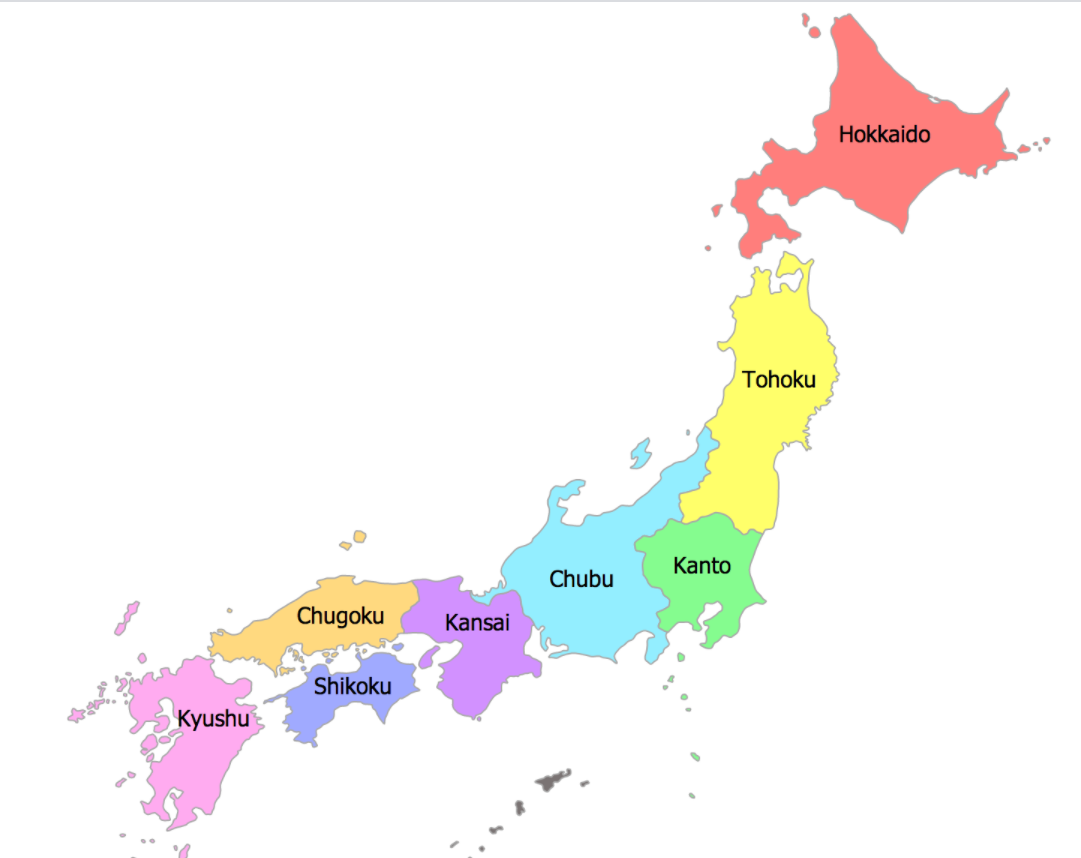

From north to south, the traditional regions are:

- __Hokkaidō__ (the island of Hokkaidō and nearby islands, population: 5,507,456, largest city: Sapporo)
- __Tōhoku__ region (northern Honshū, population: 9,335,088, largest city: Sendai)
- __Kantō__ region (eastern Honshū, population: 42,607,376, largest city: Tokyo)
- __Chūbu__ region (central Honshū, including Mt. Fuji, population: 21,714,995, largest city: Nagoya), sometimes divided into:
  - Hokuriku region (northwestern Chūbu, largest city: Kanazawa)
  - Kōshin'etsu region (northeastern Chūbu, largest city: Niigata)
    - Tōkai region (southern Chūbu, largest city: Nagoya)
- __Kansai__ or Kinki region (west-central Honshū, including the old capital, - - Kyoto, population: 22,755,030, largest city: Osaka)
- __Chūgoku__ region (western Honshū, population: 7,561,899, largest city: Hiroshima)
- __Shikoku__ (island, population: 3,977,205, largest city: Matsuyama)
- __Kyūshū__ (island, population: 14,596,977, largest city: Fukuoka) which includes:
  - Northern Kyushu: Fukuoka, Saga, Nagasaki and Ōita (largest city: Fukuoka)
  - Southern Kyushu: Kumamoto, Miyazaki and Kagoshima (largest city: Kagoshima)
  - Okinawa (largest city: Naha)

[참고문헌 : Kaggle_A Japanese Journey]('https://www.kaggle.com/asindico/a-japanese-journey')

__지역별 레스토랑 위치 시각화__

In [82]:
# folium은 지도 시각화에 아주 유용한 모듈
import folium
from folium import plugins

In [83]:
# 지역별 레스토랑 위치 지도 그리기
location = data['as'].groupby(['air_store_id', 'air_genre_name'])[['latitude', 'longitude']].mean().reset_index()
locationlist = location[['latitude', 'longitude']]  # 시각화를 위해 위도, 경도 정보가 필요하다
locationlist = locationlist.values.tolist()
map2 = folium.Map(location=[39, 139], 
                        tiles = "cartodbpositron", width=800, height=500,
                        zoom_start = 5)
marker_cluster=plugins.MarkerCluster().add_to(map2)
for point in range(0, len(location)):
    folium.Marker(locationlist[point], popup=location['air_genre_name'][point], 
    icon=folium.Icon(color='white', icon_color='red', 
                     #icon='fa fa-info-circle',
                     icon='fa fa-circle-o-notch fa-spin',
                     angle=0, 
                     prefix='fa')).add_to(marker_cluster)
map2

__지역별 레스토랑 현황__

Text(0, 0.5, '지역 구분')

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 333 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 332 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 333 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 332 missing from current font.
  font.set_text(s, 0, flags=flags)


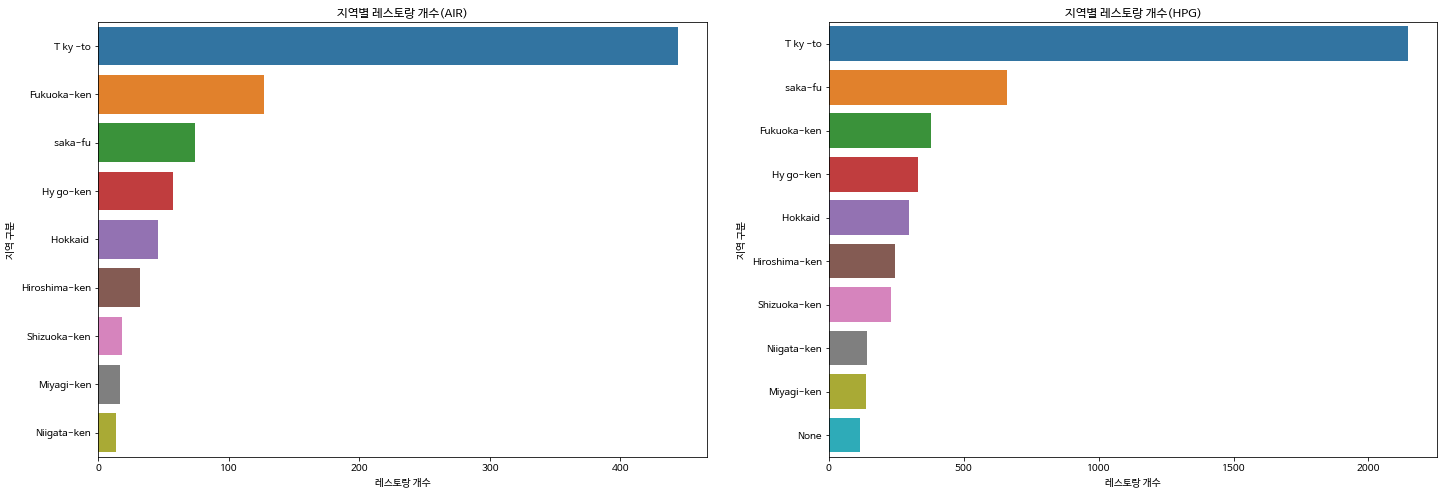

In [84]:
# 지역별 레스토랑 개수(Air_store) 시각화
data['as']['air_area'] = data['as']['air_area_name'].str.split(' ').str[0]  # air_area_name 컬럼에서 ' ' 기준으로 문자열을 split한 뒤 첫번째 문자열을 가져와 'air_area'컬럼에 담아준다.
air_res = data['as'].groupby(['air_area'], as_index=False)['air_store_id'].count().sort_values('air_store_id', ascending=False)

f,ax = plt.subplots(1,2, figsize=(24,8)) 
sns.barplot(data=air_res, x='air_store_id', y='air_area', ax=ax[0]) 
ax[0].set_title('지역별 레스토랑 개수(AIR)')
ax[0].set_xlabel('레스토랑 개수')
ax[0].set_ylabel('지역 구분')

# 지역별 레스토랑 개수(HPG_store) 시각화
data['hs']['hpg_area'] = data['hs']['hpg_area_name'].str.split(' ').str[0]
data['hs']['hpg_area'].replace('Osaka', 'Ōsaka-fu', inplace=True)
data['hs']['hpg_area'].replace('Kanagawa-ken', 'Tōkyō-to', inplace=True) # 간토 지방 -> 도쿄로 분류
data['hs']['hpg_area'].replace('Saitama-ken', 'Tōkyō-to', inplace=True) # 간토 지방 -> 도쿄로 분류
# 미해결 : 결측치가 없다고 생각했는데 area의 'None' 형태의 str 데이터가 있었다. 이를 추가로 drop 해주면 좋을 것 같다.
# data['hs'].loc[data['hs'].hpg_area == 'Kanagawa-ken']

hpg_res = data['hs'].groupby(['hpg_area'], as_index=False)['hpg_store_id'].count().sort_values('hpg_store_id', ascending=False) 

sns.barplot(data=hpg_res, x='hpg_store_id', y='hpg_area', ax=ax[1])
ax[1].set_title('지역별 레스토랑 개수(HPG)')
ax[1].set_xlabel('레스토랑 개수')
ax[1].set_ylabel('지역 구분')

__시사점__
- 지역별로 레스토랑의 개수를 시각화 해보았는데 전처리 시 추가적으로 지역별로 어떤 genre의 레스토랑이 있는지도 확인해볼 필요가 있을 것 같다.
- HPG 플랫폼에 지역 정보가 None 값이 존재한다. 문자열로 되어 있어 결측치 집계 시엔 집계 되지 않았는데 개수가 많지 않아 필요 시 drop해도 될 것 같다.

__지역별 레스토랑 방문객수__

In [85]:
air = pd.merge(data['ar'], data['as'], how='inner', on='air_store_id')
hpg = pd.merge(data['hr'], data['hs'], how='inner', on='hpg_store_id')
rel = data['id']
air_rel = pd.merge(air, rel, how='left', on='air_store_id')
hpg_rel = pd.merge(hpg, rel, how='left', on='hpg_store_id')
full = pd.merge(air_rel, hpg_rel, how='outer')

In [86]:
# KMeans 클러스터링 기법을 활용해 위도, 경도 지표를 가지고 지역별로 clsutering 해준다.
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=10, random_state=0).fit(full[['longitude', 'latitude']])
full['cluster'] = kmeans.predict(full[['longitude', 'latitude']])

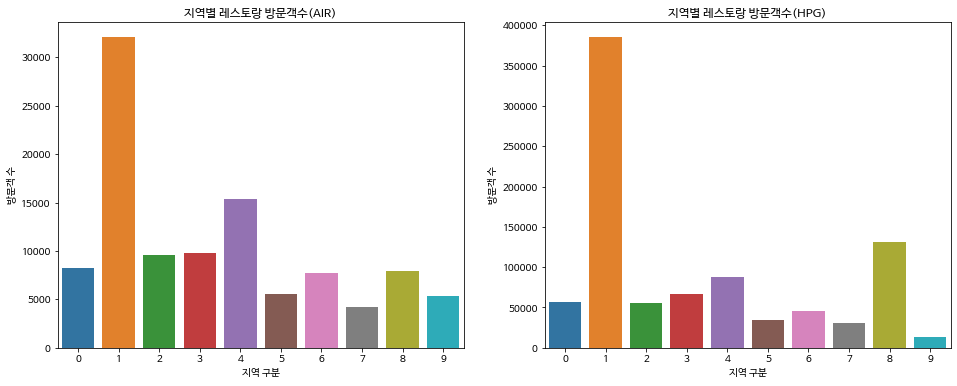

In [87]:
# 지역별 레스토랑 방문횟수
f, ax = plt.subplots(1,2, figsize=(16,6))
hist_clust = full.groupby(['cluster'],as_index=False).count()

sns.barplot(x=hist_clust.cluster, y=hist_clust.air_store_id, ax=ax[0])
ax[0].set_title('지역별 레스토랑 방문객수(AIR)')
ax[0].set_xlabel('지역 구분')
ax[0].set_ylabel('방문객 수')

sns.barplot(x=hist_clust.cluster, y=hist_clust.hpg_store_id, ax=ax[1])
ax[1].set_title('지역별 레스토랑 방문객수(HPG)')
ax[1].set_xlabel('지역 구분')
ax[1].set_ylabel('방문객 수')

plt.show()

  __시사점__
  - AIR : 도쿄, 후쿠오카, 니가타 순으로 방문객 수가 많다. 
  - HPG :  도쿄, 오사카, 후쿠오카 순으로 방문객 수가 많다.
  - 지역별 레스토랑 수와 방문객 수가 비례 관계 있는 것으로 보인다.
  - 추가적으로 해당 지역의 인구 규모 대비 방문객 수를 체크해볼 수 있을 것 같다.

__< 지역 클러스터 값 정보 >__
- Cluster 0 : Hiroshima
- Cluster 1 : Tokyo
- Cluster 2 : Hokkaido Sapporo
- Cluster 3 : Hyogo
- Cluster 4 : Fukuoka
- Cluster 5 : Niigata
- Cluster 6 : Shizuoka
- Cluster 7 : Miyagi
- Cluster 8 : Osaka
- Cluster 9 : Hokkaido Asahikawa

### Store ID 정보

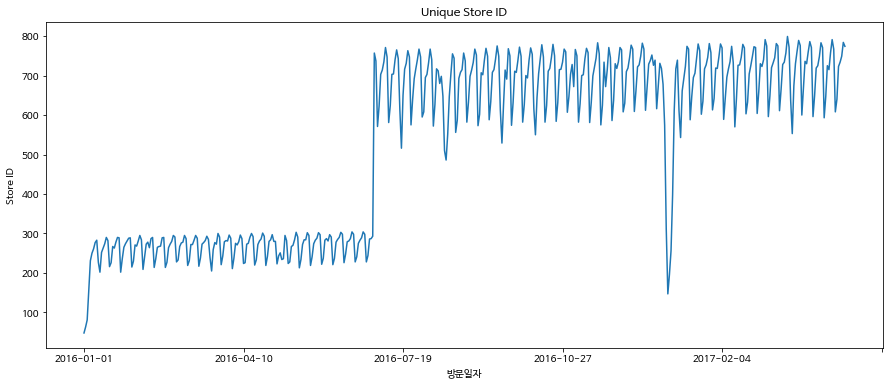

In [88]:
f,ax = plt.subplots(1,1, figsize=(15,6))
stores = data['tra'].groupby(['visit_date'])['air_store_id'].size()
stores.plot(kind='line', ax=ax)
plt.xlabel("방문일자")
plt.ylabel("Store ID")
plt.title("Unique Store ID")
plt.show()

__시사점__ 
- AirREGI(이하 'AIR') 방문자 DB가 담겨있는 테이블이다.
- 약 800여개의 Store ID 정보가 있는데 __2016년 7월을 기점으로 Store ID 숫자가 급증__하였다. 이는 새로 문을 연 레스토랑이 많아졌다기 보다는 해당 플랫폼을 이용하는 레스토랑의 숫자가 많아졌다고 예측해볼 수 있다.
- 반면에 __2017년 1월에 Store ID 숫자가 급감__하였는데 이는 해당 기간에는 문을 닫았다는 것으로 추측할 수 있는데 __골든위크 기간의 방문자 데이터 예측 시 이상치__로 볼 수 있는 정보인 것 같다.
- 그래프에서의 진폭은 주기적인 것으로 보아 평일/주말의 영향으로 인해 생긴 것으로 생각된다.

### 일자별 방문 고객 및 예약 현황

__간단한 전처리__

In [89]:
data['tra'] = pd.merge(data['tra'], data['as'], how='left', on=['air_store_id'])  # air_store_id 기준 merge air_store_info 조인
data['tra'] = pd.merge(data['tra'], data['hol'], how='left', on=['visit_date'])
data['tra'].sort_values(by='visit_date', ignore_index=True, inplace=True)
data['tra']['visit_date'] = pd.to_datetime(data['tra']['visit_date'])
data['tra']['dow'] = data['tra']['visit_date'].dt.dayofweek  # dt.dayofweek : 날짜를 요일로 변환, Monday(0)부터 시작
                                                             # 미해결 : dow 숫자값을 문자값(월/화/수~) 형태로 변환해주어야함 
data['tra']['year'] = data['tra']['visit_date'].dt.year  # dt.year : 날짜에서 연도 반환(yyyy)
data['tra']['month'] = data['tra']['visit_date'].dt.month  # dt.month : 날짜에서 월 반환(mm)
data['tra']['day'] = data['tra']['visit_date'].dt.day  # dt.day : 날짜에서 일자 반환(dd)
data['tra']['visit_date'] = data['tra']['visit_date'].dt.date  # dt.date : yyyy-mm-dd 로 변환(object)

In [90]:
data['ar'] = pd.merge(data['ar'], data['as'], how='left', on=['air_store_id'])
data['ar']['visit_datetime'] = pd.to_datetime(data['ar']['visit_datetime'])
data['ar']['visit_hour'] = data['ar']['visit_datetime'].dt.hour  # dt.hour : 날짜에서 시간만 반환
data['ar']['visit_date'] = data['ar']['visit_datetime'].dt.date  # dt.date : yyyy-mm-dd 로 변환(object)
data['ar']['reserve_datetime'] = pd.to_datetime(data['ar']['reserve_datetime'])
data['ar']['reserve_hour'] = data['ar']['reserve_datetime'].dt.hour  
data['ar']['reserve_date'] = data['ar']['reserve_datetime'].dt.date 
# 실제 방문시간-예약시점 차이
data['ar']['reserve_visit_diff'] = data['ar'].apply(lambda r: (r['visit_datetime'] - r['reserve_datetime']).days, axis=1)
data['ar'].rename(columns={'reserve_visitors':'air_reserve_visitors'}, inplace=True) 

In [91]:
data['hr'] = pd.merge(data['hr'], data['id'], how='inner', on=['hpg_store_id'])
data['hr'] = pd.merge(data['hr'], data['hs'], how='left', on=['hpg_store_id'])
data['hr']['visit_datetime'] = pd.to_datetime(data['hr']['visit_datetime'])
data['hr']['visit_hour'] = data['hr']['visit_datetime'].dt.hour  # dt.hour : 날짜에서 시간만 반환
data['hr']['visit_date'] = data['hr']['visit_datetime'].dt.date  # dt.date : yyyy-mm-dd 로 변환(object)
data['hr']['reserve_datetime'] = pd.to_datetime(data['ar']['reserve_datetime'])
data['hr']['reserve_hour'] = data['hr']['reserve_datetime'].dt.hour  
data['hr']['reserve_date'] = data['hr']['reserve_datetime'].dt.date 
# 실제 방문시간-예약시점 차이
data['hr']['reserve_visit_diff'] = data['hr'].apply(lambda r: (r['visit_date'] - r['reserve_date']).days, axis=1) 
data['hr'].rename(columns={'reserve_visitors':'hpg_reserve_visitors'}, inplace=True) 
# 미해결 : 시각화 하지 못함

__일별 방문/예약 현황__

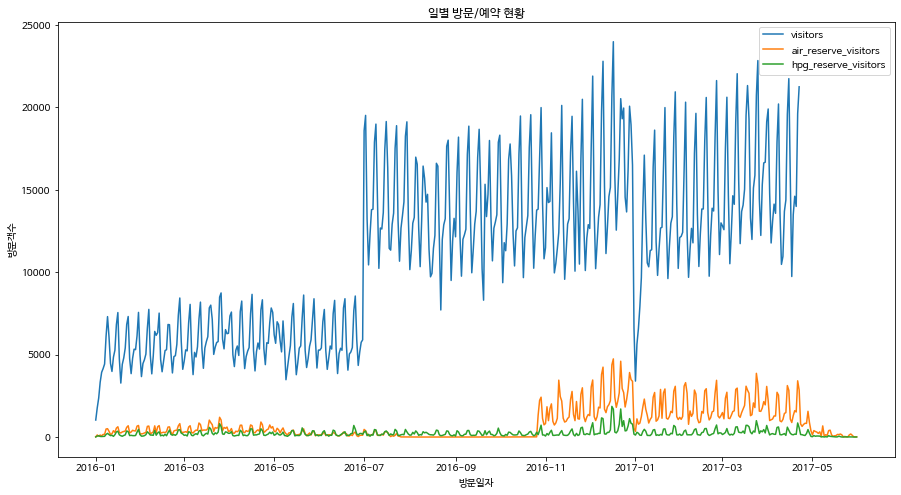

In [92]:
f,ax = plt.subplots(1,1,figsize=(15, 8))
plt1 = data['tra'].groupby('visit_date', as_index=False)['visitors'].sum()
plt1.plot(x='visit_date', y='visitors', ax=ax)

plt2 = data['ar'].groupby('visit_date', as_index=False)['air_reserve_visitors'].sum()
plt2.plot(x='visit_date', y='air_reserve_visitors', ax=ax)

plt3 = data['hr'].groupby('visit_date', as_index=False)['hpg_reserve_visitors'].sum()  
plt3.plot(x='visit_date', y='hpg_reserve_visitors', ax=ax)

plt.xlabel('방문일자')
plt.ylabel('방문객수')
plt.title('일별 방문/예약 현황')
plt.show()

__시사점__
- 앞에서 언급했던 2016년 7월 Store ID 증가와 더불어 실제 방문객 수가 급증한 것으로 보아 예약 시스템에 새로운 식당의 추가, 방문자 집계 시스템 개편. 예약 프로모션 등의 이슈가 있었을 것으로 예상된다.  
- 2017년 1월도 마찬가지로 방문객 수가 감소한 것으로 보아 연말/연초에 문을 닫았던 레스토랑이 많은 것으로 예상된다.
- HPG를 통한 예약보다 AIR를 통한 예약 수가 더 많다.
- 그래프를 통해 예약 데이터가 실제 방문자 수에 비해 저조한 것을 볼 수 있다. __즉, 예약을 통한 방문객 보다 워크인(Walk-in) 방문객이 더 많은 것을 알 수 있다.__
- 해당 데이터를 가지고 예약 No-show, 재방문 여부 등에 대한 정보를 파악할 수는 없다.

### 방문객수 현황

__월별/일자별 방문객 수__

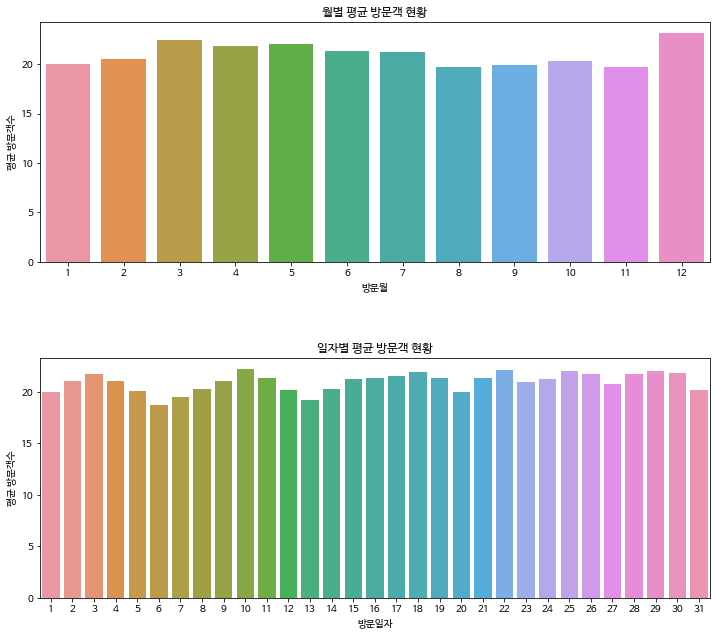

In [93]:
f,ax = plt.subplots(2,1,figsize=(12, 10))
month_vis = data['tra'].groupby('month', as_index=False)['visitors'].mean()
sns.barplot(data=month_vis, x='month', y='visitors', ax=ax[0])
ax[0].set_xlabel('방문월')
ax[0].set_ylabel('평균 방문객수')
ax[0].set_title('월별 평균 방문객 현황')

temp = data['tra'].groupby('day', as_index=False)['visitors'].mean()
sns.barplot(data=temp, x='day', y='visitors', ax=ax[1])
ax[1].set_xlabel('방문일자')
ax[1].set_ylabel('평균 방문객수')
ax[1].set_title('일자별 평균 방문객 현황')

plt.subplots_adjust(left=0.125, bottom=0.1,  right=0.9, top=0.9, wspace=0.2, hspace=0.4)
plt.show()

__시사점__
- 월별 방문객 현황  
  - 월별로 확인했을 때 방문객 수가 가장 많은 달은 12월이다. (송년회 영향이라고 추측 해본다.) 
  - 12월 다음으로는 봄(3~5월)이 방문객 수가 많다. 4월 말 ~ 5월 초 골든 위크의 영향이 어느정도 있지 않을까 예상된다.

- 일자별 방문객 현황  
  - __평균적으로 매월 3일, 10일, 22일이 평균 방문객 수가 가장 높다.__
  - 평균적으로 매월 6일, 13일, 20일, 31일 방문객 수가 감소하고 있다.

__요일/공휴일 여부에 따른 방문객 수__

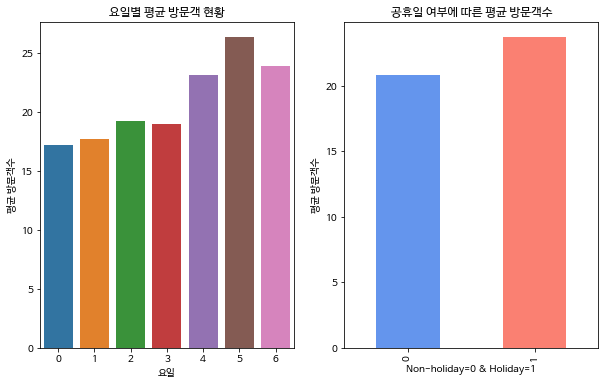

In [94]:
f,ax = plt.subplots(1,2,figsize=(18, 6))
dow_vis = data['tra'].groupby('dow', as_index=False)['visitors'].mean()
sns.barplot(data=dow_vis, x='dow', y='visitors', ax=ax[0])
# plt1.plot.bar(x='dow', ax=ax)
ax[0].set_xlabel('요일')
ax[0].set_ylabel('평균 방문객수')
ax[0].set_title('요일별 평균 방문객 현황')

temp = data['tra'].groupby('holiday_flg')['visitors'].mean()
temp.plot.bar(x='holiday_flg', y='visitors', color=['cornflowerblue', 'salmon'], figsize=(10,6), ax=ax[1])
ax[1].set_xlabel('Non-holiday=0 & Holiday=1')
ax[1].set_ylabel('평균 방문객수')
ax[1].set_title('공휴일 여부에 따른 평균 방문객수')

plt.show()  #? 숫자로 된 요일을 문자열로 바꾸는법

__시사점__
- 요일별 방문객 현황  
  - 상식적으로 생각할 수 있는 예상대로 평일(월-목) 보다 주말(금-일)의 방문객 수가 많다.
  - 방문객 수가 가장 많은 날은 토요일이다.
- 공휴일 여부에 따른 방문객 현황
  - holiday 의 방문객 수가 상대적으로 많다는 것은 holiday에도 레스토랑들은 가게 문을 닫지 않고 영업을 한다고 볼 수 있다.
  - __공휴일의 경우 평일인 경우도 있기 때문에 데이터 전처리 시 공휴일이 있는 기간에 대한 방문객수 추이를 좀 더 유심있게 관찰해 볼 필요가 있을 것 같다.__

### 방문시간 현황

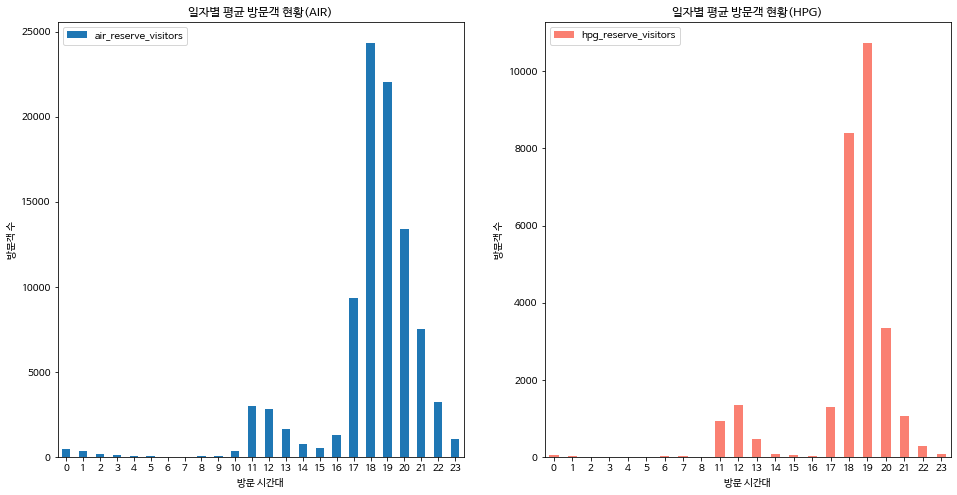

In [95]:
f, ax = plt.subplots(1,2, figsize=(16,8))
vis_time1 = data['ar'].groupby(['visit_hour'])['air_reserve_visitors'].count().to_frame()
vis_time1.plot(kind='bar', ax=ax[0])
ax[0].set_title('일자별 평균 방문객 현황(AIR)')
ax[0].set_xlabel('방문 시간대')
ax[0].set_ylabel('방문객 수')
ax[0].tick_params(axis='x', labelrotation=0)

vis_time2 = data['hr'].groupby(['visit_hour'])['hpg_reserve_visitors'].count().to_frame()
vis_time2.plot(kind='bar', color='salmon', ax=ax[1])
ax[1].set_title('일자별 평균 방문객 현황(HPG)')
ax[1].set_xlabel('방문 시간대')
ax[1].set_ylabel('방문객 수')
ax[1].tick_params(axis='x', labelrotation=0)

plt.show()

__시사점__
- 저녁 시간대인 18시에서 20시 사이에 방문객 수가 가장 많은 것을 확인할 수 있다.

### 장르별 레스토랑 현황

__장르별 레스토랑 Market share__

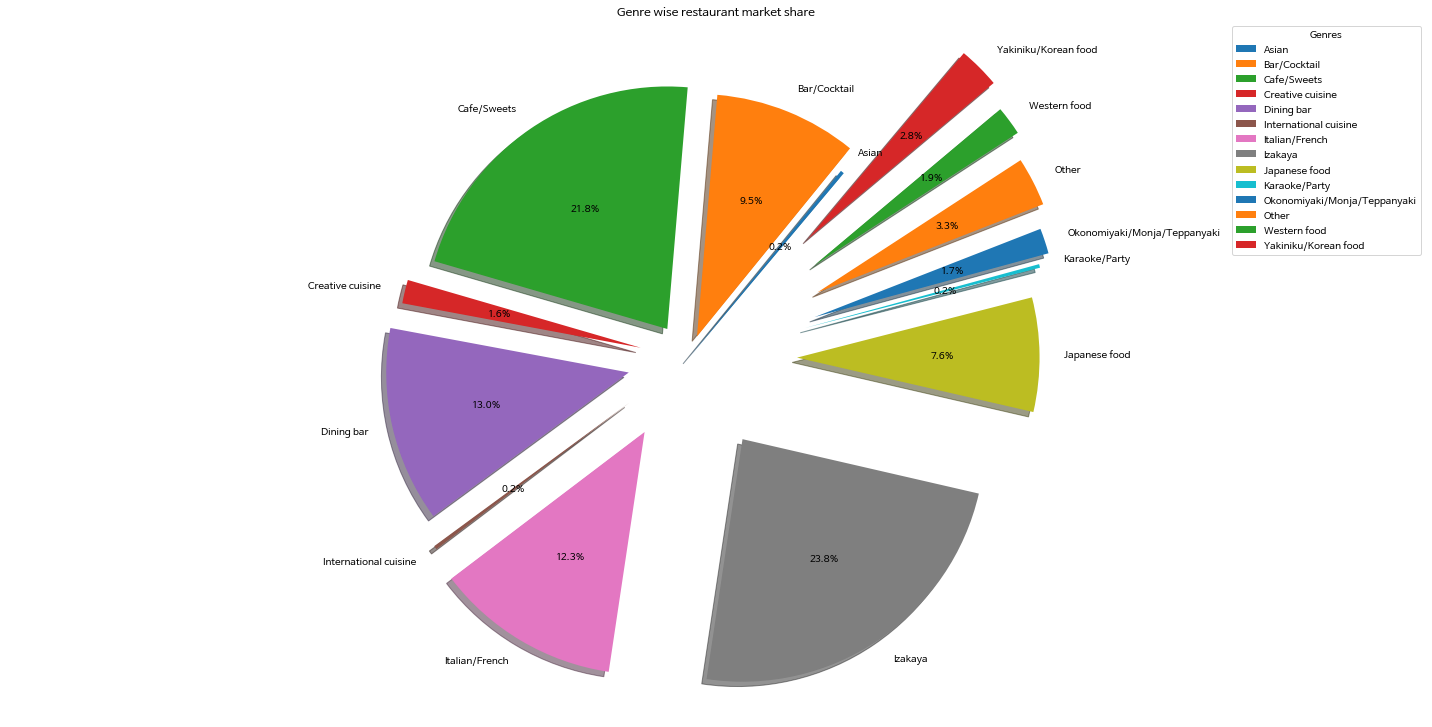

In [96]:
temp =data['as'].groupby(['air_genre_name'],as_index=False)['air_store_id'].count()
labels = temp.air_genre_name.values
sizes = temp.air_store_id.values
explode = (0, 0.1, 0.15, 0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7)  
f,ax = plt.subplots(figsize=(20,10))
ax.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=50)
# Equal aspect ratio ensures that pie is drawn as a circle
ax.axis('equal')  
plt.tight_layout()
plt.legend(title='Genres')
plt.title('Genre wise restaurant market share')
plt.show()

__시사점__
- 레스토랑을 14개의 카테고리로 분류하고 있다. 
- 이자카야가 23.8%로 가장 많은 비중을 차지하며, 다음으로 카페/디저트가 21.8%를 차지하고 있다.

__장르별 레스토랑 분류(AIR vs. HPG)__

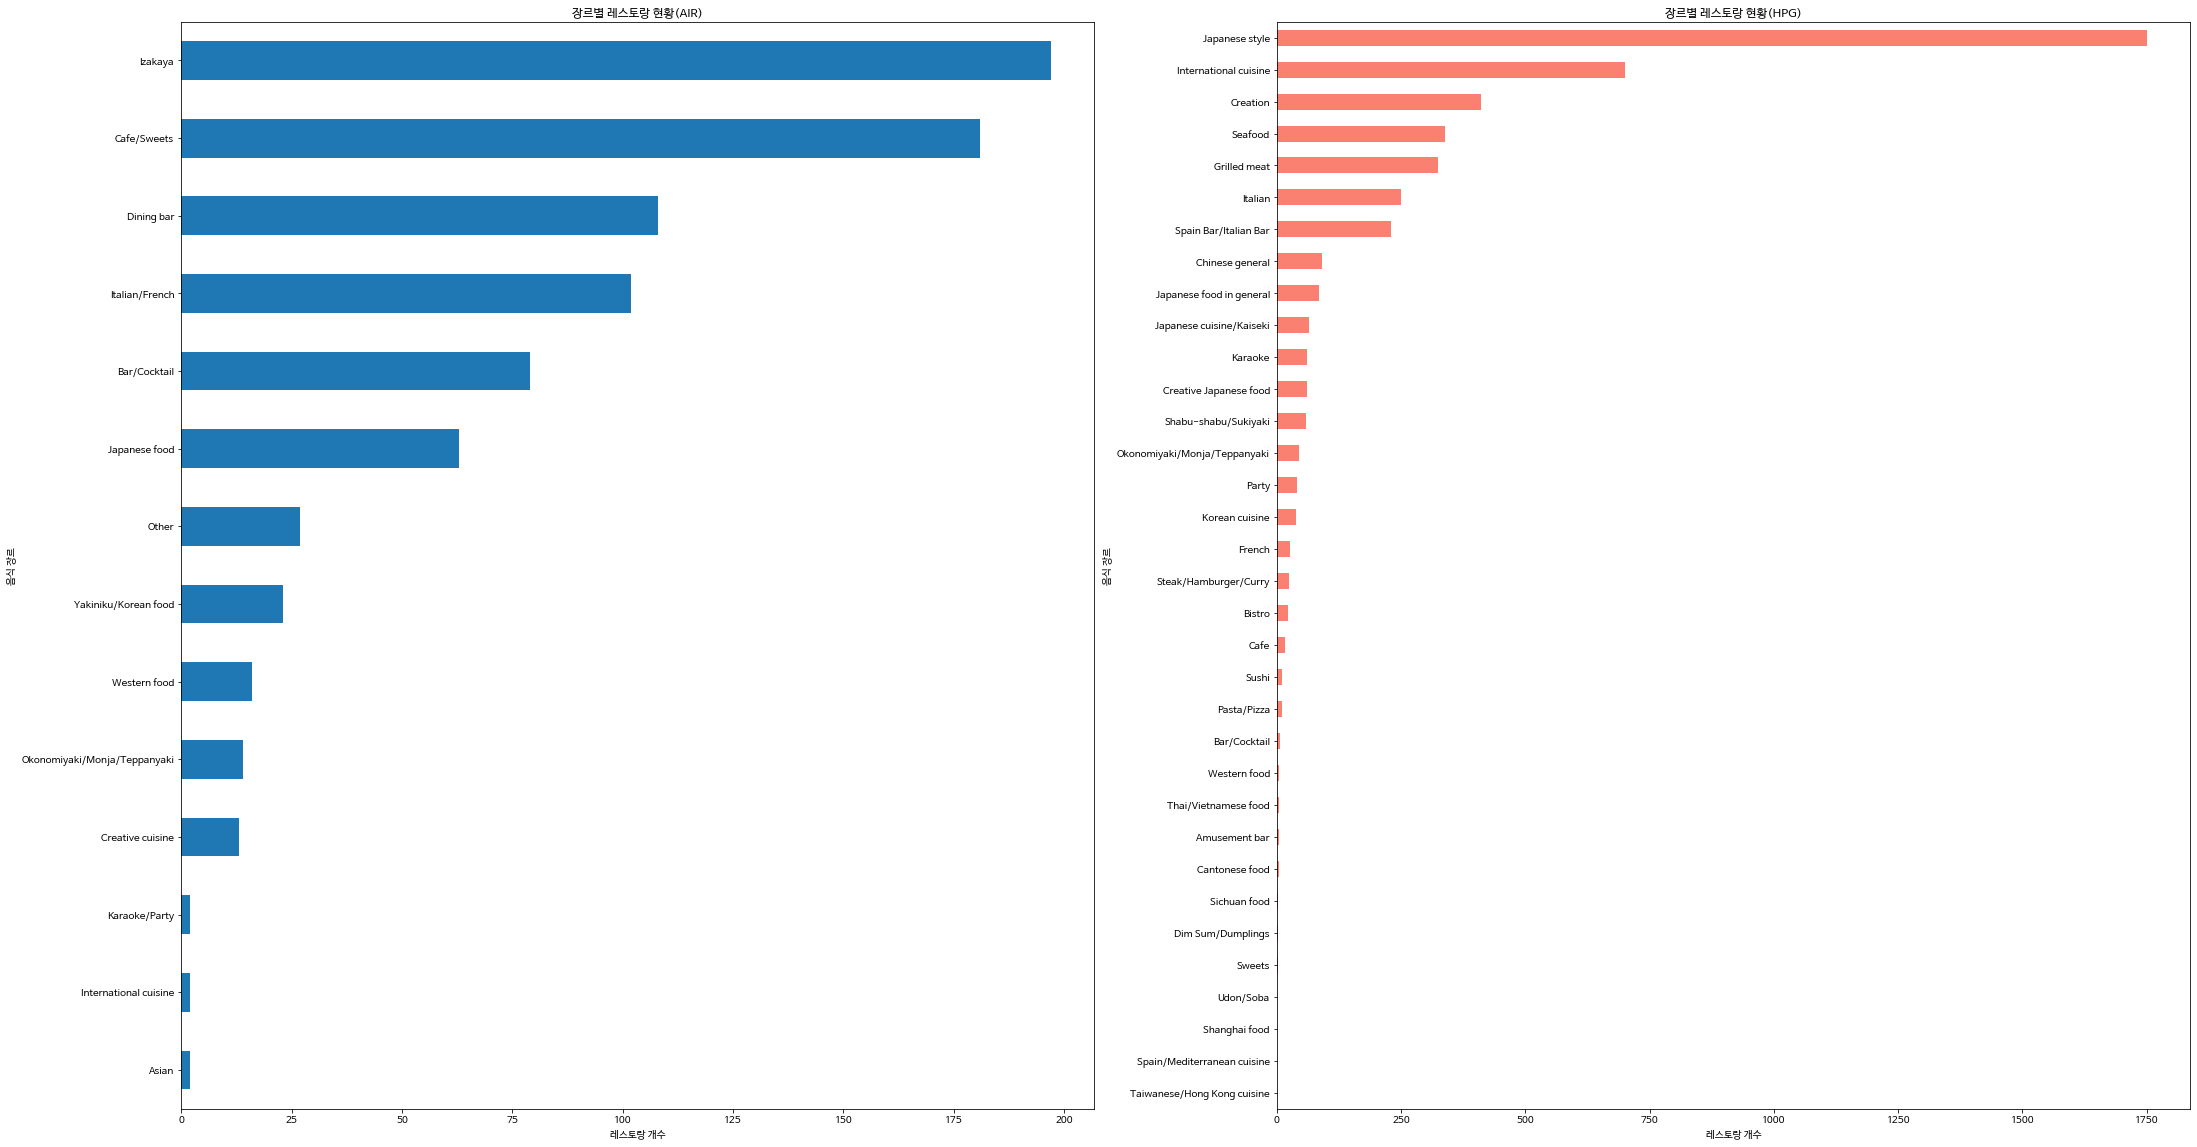

In [97]:
f, ax = plt.subplots(1, 2, figsize=(36,20))

air_genre = data['as'].groupby(['air_genre_name'])['air_genre_name'].count().sort_values()
air_genre.plot.barh(x='air_genre_name', ax=ax[0])
ax[0].set_title('장르별 레스토랑 현황(AIR)')
ax[0].set_xlabel('레스토랑 개수')
ax[0].set_ylabel('음식 장르')

hpg_genre = data['hs'].groupby(['hpg_genre_name'])['hpg_genre_name'].count().sort_values()
hpg_genre.plot.barh(x='hpg_genre_name', color='salmon', ax=ax[1])
ax[1].set_title('장르별 레스토랑 현황(HPG)')
ax[1].set_xlabel('레스토랑 개수')
ax[1].set_ylabel('음식 장르')


plt.show()

__시사점__
- AIR : 레스토랑을 14개의 카테고리로 분류하고 있다. 이자카야, 카페/디저트 레스토랑이 가장 많다.
- HPG : 레스토랑의 장르가 매우 다양하게 분류되어 있다.

__고객들이 가장 많이 찾는 레스토랑 Genre는?__

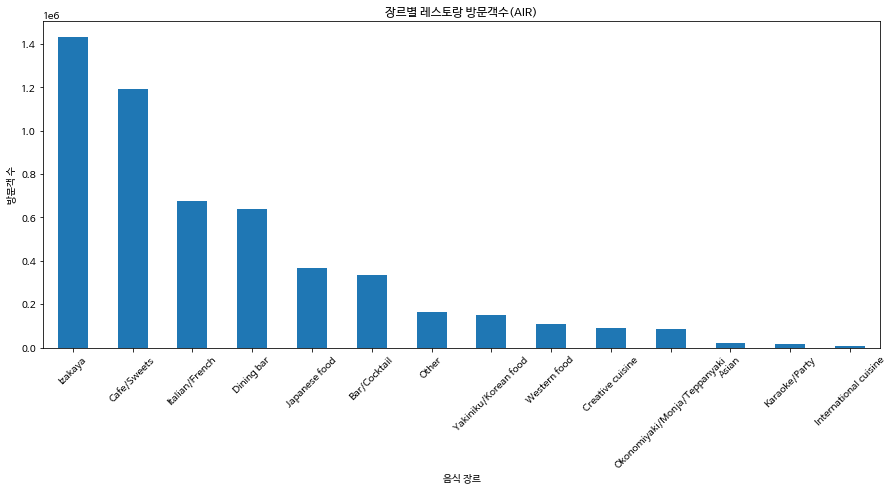

In [98]:
f, ax = plt.subplots(1, 1, figsize=(15,6))
air_genre = data['tra'].groupby(['air_genre_name'])['visitors'].sum().sort_values(ascending=False)
air_genre.plot.bar(x='air_genre_name', ax=ax)

plt.title('장르별 레스토랑 방문객수(AIR)')
plt.xticks(rotation=45)
plt.xlabel('음식 장르')
plt.ylabel('방문객 수')
plt.show()

__시사점__
- Market share와 실제 방문객 수를 비교 했을 때 약간의 순위 차이가 존재하긴 하지만 수요와 공급이 비례하게 나타나는 것 같다.
  - Market share : Izakaya > Cafe/Sweets > Dining bar > Italian/French > Bar/Cocktail > Japanese food 순
  - __장르별 레스토랑의 방문객 : Izakaya > Cafe/Sweets > Italian/French > Dining bar > Japanese food > Bar/Cocktail__ 순
- Western, Asian, International cuisine 등은 일본인들에게 별로 인기가 없는 편이다.
- 만약 골든위크 기간에 Izakaya, Cafe/Sweets 등의 레스토링이 문을 닫는다면 방문객 수는 연말/연초 처럼 급감할 것이다.

## 참고문헌
- [Github: Case Study - 1 (Recruit Restaurant Visitor Forecasting)]('https://github.com/junaidnasirkhan/Restaurant-Visitor-Forecasting/blob/master/Restaurant%20Visitor%20Forecasting.ipynb')
- [Kaggle: 
Restaurant Visitor Forecasting EDA with R (한글 번역)]('https://www.kaggle.com/maestroyi/restaurant-visitor-forecasting-eda-with-r?fbclid=IwAR2Xjy5JGKuogn0H2bMMdthC1TFkbZQY5MJe_Mv7Y7eksVj9BQbEdFWTTQ0')


# Feature Engineering

## 1. Load the Dataset

#### **Why 'visit_data'? (why not 'reserve_data)'**   
As we saw from the EDA, It's hard to find a strong correlation between the 'visitors' and 'hpg_reserve_data' and 'air_reserve_data'.   

#### **Why 'air_visit_data'? (why not hpg_data)**   
The common number of restaruants between AIR platform and HPG platform is only 150, which is really small number of stores. Moreover, Our sample_submission.csv tells us that we only need to predict the restaurants on AIR platform. So I dropped HPG's reserve data from the feature engineering.


So I only used the below 4 dataset to do the feature engineering + alpha with the preprocessed-version of the weather data. I will mentino this again in the (5) preprocessed weather data section.

In [2]:
import pandas as pd
import numpy as np

data_path = '/content/drive/MyDrive/aiffel/hackaton_1_data/data/';
dest_path = '/content/drive/MyDrive/aiffel/hackaton_1_data/';

air_visit = pd.read_csv(data_path + 'air_visit_data.csv')
date_info = pd.read_csv(data_path + 'date_info.csv')
submission = pd.read_csv(data_path + 'sample_submission.csv')
air_store_info = pd.read_csv(data_path + 'weather/air_store_info_with_nearest_active_station.csv')



In [3]:
dest_path = '/content/drive/MyDrive/aiffel/hackaton_1_data/';


### (1) Resample the visiting data by days

#### Dealing with Time Series dataset -> resampling, rolling, shifting
 I will mainly focus on following so-called `rolling statistics` here. It is important to remember this data is **time series**, and we need to keep rolling features based on time.What this means is that I will resample the given visiting data by day so if there are no data points, the number of visits for those days be 0.    

- **Resampling**: basicallty means representing the data with a different frequency. (시간 간격을 조정)
- **Rolling**: Rolling is a very useful operation for time series data. Rolling means creating a rolling window with a specified size and perform calculations on the data in this window which, of course, rolls through the data. (임의의 시간 간격 window를 만들고, 그 안에서 통계적 aggregation을 구할 수 있다)

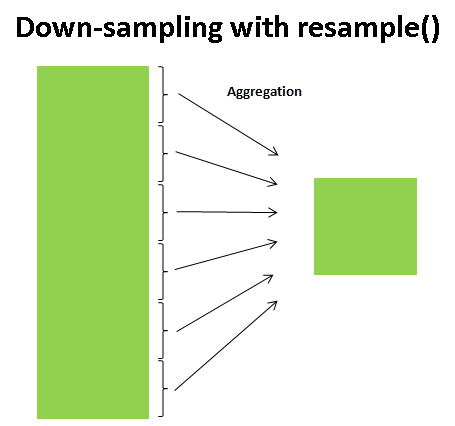

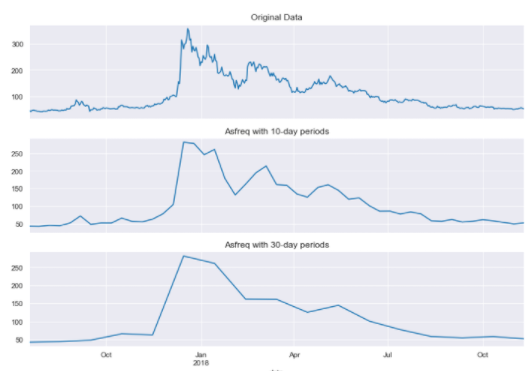

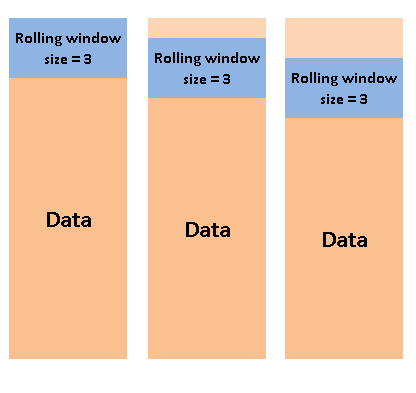

REF: https://towardsdatascience.com/time-series-analysis-resampling-shifting-and-rolling-f5664ddef77e

Here is a helper function to resample the given visiting data by day, and later I will add 0 if there are no data points. 

In [4]:
def resample_by_visitors(group):
  return group['visitors'].resample('1d').sum() # set frequency to 1d

 Also, one more important thing is that to keep track of if the datapoint is added due to resampling, so I added the column `was_na`.

In [5]:
air_visit.index = pd.to_datetime(air_visit['visit_date']) # convert to datetime type
air_visit = air_visit.groupby('air_store_id').apply(resample_by_visitors).reset_index()
air_visit['visit_date'] = air_visit['visit_date'].dt.strftime('%Y-%m-%d') # Use Series.dt.strftime() function to convert the dates in the given series object to the specified date format.
air_visit['was_na'] = air_visit['visitors'].isnull() # Use isna()?
air_visit['visitors'].fillna(0, inplace=True)

air_visit.head()

air_store_id  visit_date  visitors  was_na
0  air_00a91d42b08b08d9  2016-07-01        35   False
1  air_00a91d42b08b08d9  2016-07-02         9   False
2  air_00a91d42b08b08d9  2016-07-03         0   False
3  air_00a91d42b08b08d9  2016-07-04        20   False
4  air_00a91d42b08b08d9  2016-07-05        25   False

### (2) Handle Holidays

From the calendar information, apart from the `day of the week` and `is weekend`, I will add two boolean-float attributes to indicate if the previous or the next day is holiday, since from the **EDA** we checked the calendar information matters with those holidays for the reservation rates.

In [6]:
date_info.rename(columns={'holiday_flg': 'is_holiday', 'calendar_date': 'visit_date'}, inplace=True)
date_info['prev_day_is_holiday'] = date_info['is_holiday'].shift().fillna(0)
date_info['next_day_is_holiday'] = date_info['is_holiday'].shift(-1).fillna(0)

date_info.head()

visit_date day_of_week  is_holiday  prev_day_is_holiday  next_day_is_holiday
0  2016-01-01      Friday           1                  0.0                  1.0
1  2016-01-02    Saturday           1                  1.0                  1.0
2  2016-01-03      Sunday           1                  1.0                  0.0
3  2016-01-04      Monday           0                  1.0                  0.0
4  2016-01-05     Tuesday           0                  0.0                  0.0

### (3) Create Test Dataset

We already got some hint from the `sample_submission` file. We can extract the `store_id` and the `date` from the `id` column.    
And also I will sort the dataset in order to make sure the data has the same order with the `sample_submission`   
    
I added `is_test` column to ensure this is the test dataset. Also added `test_number` as an index and `visitors` as the results, but its `NaN` for now. 

In [7]:
submission['air_store_id'] = submission['id'].str.slice(0, 20)
submission['visit_date'] = submission['id'].str.slice(21)
submission['is_test'] = True
submission['visitors'] = np.nan
submission['test_number'] = range(len(submission))

submission.head()

id  visitors  ... is_test test_number
0  air_00a91d42b08b08d9_2017-04-23       NaN  ...    True           0
1  air_00a91d42b08b08d9_2017-04-24       NaN  ...    True           1
2  air_00a91d42b08b08d9_2017-04-25       NaN  ...    True           2
3  air_00a91d42b08b08d9_2017-04-26       NaN  ...    True           3
4  air_00a91d42b08b08d9_2017-04-27       NaN  ...    True           4

[5 rows x 6 columns]

### (4) Format the Training set and the Test set Properly

To merge the training set and the test set, we need to format them properly.    
Let's concatenate `air_visit` and `submission`, and merge the concatenated data with `visit_date` that I created above.   

Also, Fill in the `is_test` column to False, so later we can merge the train and test and still distinguish the train and test dataset.

In [8]:
data = pd.concat((air_visit, submission.drop('id', axis='columns')))
data['is_test'].fillna(False, inplace=True)
data = pd.merge(left=data, right=date_info, on='visit_date', how='left')
data['visitors'] = data['visitors'].astype(float)

data.head()

air_store_id  visit_date  ...  prev_day_is_holiday next_day_is_holiday
0  air_00a91d42b08b08d9  2016-07-01  ...                  0.0                 0.0
1  air_00a91d42b08b08d9  2016-07-02  ...                  0.0                 0.0
2  air_00a91d42b08b08d9  2016-07-03  ...                  0.0                 0.0
3  air_00a91d42b08b08d9  2016-07-04  ...                  0.0                 0.0
4  air_00a91d42b08b08d9  2016-07-05  ...                  0.0                 0.0

[5 rows x 10 columns]

### (5) AIR Store data

 
As mentioned above, I only used `air_store_info` since I only care about the AIR data for the stores, not HPG stores.

In [9]:
air_store_info.head()

air_store_id  air_genre_name  ... station_vincenty  station_great_circle
0  air_0f0cdeee6c9bf3d7  Italian/French  ...         1.277232              1.274882
1  air_7cc17a324ae5c7dc  Italian/French  ...         1.277232              1.274882
2  air_fee8dcf4d619598e  Italian/French  ...         1.277232              1.274882
3  air_a17f0778617c76e2  Italian/French  ...         1.277232              1.274882
4  air_83db5aff8f50478e  Italian/French  ...         3.730672              3.739835

[5 rows x 12 columns]

Then add this provided restaurants store data to the `data` dataframe by using the unique `air_store_id`.

In [10]:
data = pd.merge(left=data, right=air_store_info, on='air_store_id', how='left')
data.head()

air_store_id  visit_date  ...  station_vincenty station_great_circle
0  air_00a91d42b08b08d9  2016-07-01  ...          0.416011             0.415906
1  air_00a91d42b08b08d9  2016-07-02  ...          0.416011             0.415906
2  air_00a91d42b08b08d9  2016-07-03  ...          0.416011             0.415906
3  air_00a91d42b08b08d9  2016-07-04  ...          0.416011             0.415906
4  air_00a91d42b08b08d9  2016-07-05  ...          0.416011             0.415906

[5 rows x 21 columns]

### (6) Preprocessed Weather Data

I used the preprocessed version coming from the weather data provided by a user "Hunter McGushion" https://www.kaggle.com/huntermcgushion/rrv-weather-data .   
His data is way more useful because The reason why is that the preprocessed version contains weather station data important for joining the weather features.  

Then we need to handle the other weather datasets. This data contains **1663** files (one for each of the *1663 stations* in Japan).   
This is a multi-faceted dataset that deals with time, geography, weather, and delicious food.    

And there are so many **null values** in this dataset and the reason is there are many different types of stations/sensors are used, and some just don't capture as much data as others. Also, If the station was terminated, its values are null.   


Let's load the whole dataset and see how weather is formatted.

In [11]:
import glob

weather_dfs = []

for path in glob.glob(data_path + 'weather/1-1-16_5-31-17_Weather/*.csv'):
    weather_df = pd.read_csv(path)
    weather_df['station_id'] = path.split('\\')[-1].rstrip('.csv')
    weather_dfs.append(weather_df)

weather = pd.concat(weather_dfs, axis='rows')
weather.rename(columns={'calendar_date': 'visit_date'}, inplace=True)

weather.head()

visit_date  ...                                         station_id
0  2016-01-01  ...  /content/drive/MyDrive/aiffel/hackaton_1_data/...
1  2016-01-02  ...  /content/drive/MyDrive/aiffel/hackaton_1_data/...
2  2016-01-03  ...  /content/drive/MyDrive/aiffel/hackaton_1_data/...
3  2016-01-04  ...  /content/drive/MyDrive/aiffel/hackaton_1_data/...
4  2016-01-05  ...  /content/drive/MyDrive/aiffel/hackaton_1_data/...

[5 rows x 16 columns]

To summarize,  one file for weather station. We also know each restaurant's closest weather station.   

After reading many kernels and articles about this weather data, I agreed that only **precipitation and the temperature features** are useful for this visitor analysis.    


In [12]:
means = weather.groupby('visit_date')[['avg_temperature', 'precipitation']].mean().reset_index()
means.rename(columns={'avg_temperature': 'global_avg_temperature', 'precipitation': 'global_precipitation'}, inplace=True)
weather = pd.merge(left=weather, right=means, on='visit_date', how='left')
weather['avg_temperature'].fillna(weather['global_avg_temperature'], inplace=True)
weather['precipitation'].fillna(weather['global_precipitation'], inplace=True)

weather[['visit_date', 'avg_temperature', 'precipitation']].head()

visit_date  avg_temperature  precipitation
0  2016-01-01              3.6            0.0
1  2016-01-02              3.2            0.0
2  2016-01-03              5.5            0.0
3  2016-01-04              6.0            0.0
4  2016-01-05              6.7            0.0

Then we can clean up the dataframe so we can extract some useful features from this!

In [13]:
data['visit_date'] = pd.to_datetime(data['visit_date'])
data.sort_values(['air_store_id', 'visit_date'], inplace=True)

data.head()

air_store_id visit_date  ...  station_vincenty station_great_circle
0  air_00a91d42b08b08d9 2016-07-01  ...          0.416011             0.415906
1  air_00a91d42b08b08d9 2016-07-02  ...          0.416011             0.415906
2  air_00a91d42b08b08d9 2016-07-03  ...          0.416011             0.415906
3  air_00a91d42b08b08d9 2016-07-04  ...          0.416011             0.415906
4  air_00a91d42b08b08d9 2016-07-05  ...          0.416011             0.415906

[5 rows x 21 columns]

Looks good. Further, I had an idea to take mean of the NN closest stations from the stores. But not sure how this will impact the model.

### (7) Genre wise restaurants grouping

Since we noticed thata number of restaurants of specific genre in a local area has a huge effect on the number of visitors, so let's group the number of restaurants with the genre per each area.   
Group by 'air_genre_name', 'air_area_name', and use `as_index` to return the count of the object with group labels as the index.   

Note that the `genre_in_area` represents the number of stores of the `genre` in that specific `area`.

In [14]:
air_genres_area = air_store_info.copy()
air_genres_area = air_genres_area[['air_store_id', 'air_genre_name', 'air_area_name']].groupby(['air_genre_name', 'air_area_name'],
                                                                                              as_index = False).count()
air_genres_area = air_genres_area.rename(columns = {'air_store_id': 'total_stores_of_genre_in_area'})
air_genres_area.head()

air_genre_name  ... total_stores_of_genre_in_area
0          Asian  ...                             2
1   Bar/Cocktail  ...                             7
2   Bar/Cocktail  ...                             2
3   Bar/Cocktail  ...                             2
4   Bar/Cocktail  ...                             4

[5 rows x 3 columns]

### (8) Area wise restaurants grouping

Also, As we saw from the **EDA - pie chart**, there is a correlation between the **number of restaurants in the area** and **the number of visitors**.   
I can create `air_area` to group `air_store_id` with `air_area_name` and the count.

In [15]:
# total amount of restaurants in area
air_area = air_store_info.copy()
air_area = air_area[['air_store_id', 'air_area_name']].groupby(['air_area_name'], as_index = False).count()
air_area = air_area.rename(columns = {'air_store_id': 'total_r_in_area'})

air_area.head()

air_area_name  total_r_in_area
0         Fukuoka-ken Fukuoka-shi Daimyō               64
1  Fukuoka-ken Fukuoka-shi Hakata Ekimae               16
2       Fukuoka-ken Fukuoka-shi Imaizumi                2
3        Fukuoka-ken Fukuoka-shi Momochi                6
4       Fukuoka-ken Fukuoka-shi Shiobaru                7

As we saw from the above **EDA**, we checked the number of restaurants matter for each region, so we will add the data to the dataframe.

In [16]:
data = pd.merge(left=data, right=air_area, on='air_area_name', how='left')
data.head()

air_store_id visit_date  ...  station_great_circle total_r_in_area
0  air_00a91d42b08b08d9 2016-07-01  ...              0.415906              20
1  air_00a91d42b08b08d9 2016-07-02  ...              0.415906              20
2  air_00a91d42b08b08d9 2016-07-03  ...              0.415906              20
3  air_00a91d42b08b08d9 2016-07-04  ...              0.415906              20
4  air_00a91d42b08b08d9 2016-07-05  ...              0.415906              20

[5 rows x 22 columns]

Okay, I see `total_r_in_ara` is added at the right-most side of the table on the `data`.

### (9) Weekends, and Day of Month

#### Why do we need this?
Then let's apply some features to see if the below features can prove what we've seen in the **EDA** above about the **day of month**. We observed that there is a constant peak on the 3rd,10th, and 22nd day of the month, and also on the **weekends**. We can see a clear pattern on them.   

To keep track of this **day of month** as a parameter, I added `is_weekend` and `day_of_month`.

In [17]:
data['is_weekend'] = data['day_of_week'].isin(['Saturday', 'Sunday']).astype(int)
data['day_of_month'] = data['visit_date'].dt.day

In [18]:
data['is_weekend'].head()

0    0
1    1
2    1
3    0
4    0
Name: is_weekend, dtype: int64

In [87]:
data['day_of_month'].head()

2016-07-01    1
2016-07-02    2
2016-07-03    3
2016-07-04    4
2016-07-05    5
Name: day_of_month, dtype: int64

## 2. Preprocessing

### (1) Outliers?

Based on the EDA, the number of restaurant visits in the new year is clearly does NOT represent the rest of the year. What this means is that the outlier is a very high value. One good thing is that there is no negative values in the dataset..!

We can assume that number of visitors follow a **normal distribution** per restaurant and also define **outliers** as values ​​outside the **confidence interval.**    

The number `2.4` in the following code block is simply the **upper quantile of the normal distribution.** We recommend using `1.96` to select the top 5% of values ​​as outliers. After detecting outliers, I created a new variable called `visitors_capped` where the outliers are replaced with the maximum of the non-outliers.   

Ref: **Q**: How do you deal with outlier? **A**: Assuming that the number of visitors as a random variable with a normal distribution: https://www.kaggle.com/c/recruit-restaurant-visitor-forecasting/discussion/46939

Here, I take the log_1p to store the `visitors` results.   


#### Why take log_1p?   
The reason why logarithm is important in the time series is that the curve can be used to help better identify the compound return that the visitors to the restaurants over a period of time.   
you can check the distribution of orange: normal distribution and blue: log normal distribution

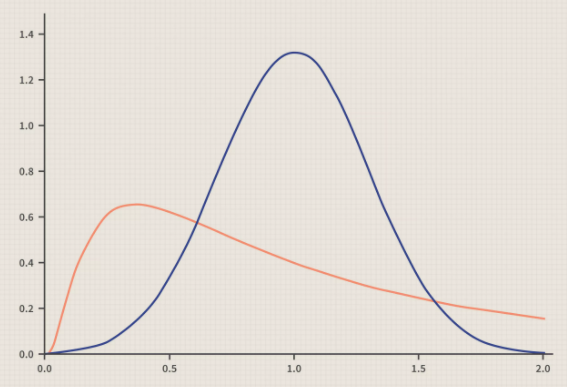

In [20]:
def find_outliers(series):
    return (series - series.mean()) > 2.4 * series.std()


def cap_values(series):
    outliers = find_outliers(series)
    max_val = series[~outliers].max() # TODO
    series[outliers] = max_val
    return series


stores = data.groupby('air_store_id')
data['is_outlier'] = stores.apply(lambda g: find_outliers(g['visitors'])).values
data['visitors_capped'] = stores.apply(lambda g: cap_values(g['visitors'])).values
data['visitors_capped_log1p'] = np.log1p(data['visitors_capped'])

data.head()

air_store_id visit_date  ...  visitors_capped visitors_capped_log1p
0  air_00a91d42b08b08d9 2016-07-01  ...             35.0              3.583519
1  air_00a91d42b08b08d9 2016-07-02  ...              9.0              2.302585
2  air_00a91d42b08b08d9 2016-07-03  ...              0.0              0.000000
3  air_00a91d42b08b08d9 2016-07-04  ...             20.0              3.044522
4  air_00a91d42b08b08d9 2016-07-05  ...             25.0              3.258097

[5 rows x 27 columns]

In [21]:
data[data["is_outlier"] == True].count()

air_store_id             4884
visit_date               4884
visitors                 4884
was_na                   4884
is_test                  4884
test_number                 0
day_of_week              4884
is_holiday               4884
prev_day_is_holiday      4884
next_day_is_holiday      4884
air_genre_name           4884
air_area_name            4884
latitude                 4884
longitude                4884
latitude_str             4884
longitude_str            4884
station_id               4884
station_latitude         4884
station_longitude        4884
station_vincenty         4884
station_great_circle     4884
total_r_in_area          4884
is_weekend               4884
day_of_month             4884
is_outlier               4884
visitors_capped          4884
visitors_capped_log1p    4884
dtype: int64

### (2) Optimization with EWM (Exponential Weighted Average)

#### What is EWM? What is the alpha value?   
**Exponential Weighted Average (EWM)** is a very good way to catch **trends** in a time series. However, they rely on the parameter alpha to model the weight of the mean. For example, if alpha is close to 1, the latest values ​​are more weighted than the previous values. Choosing an alpha is very important and there is no clear way to choose. We decided to do an optimization procedure to determine the best alpha for each store's time series by day of the week.

####  How to optimize?   
Optimization is done by differential evolution. The main reason for choosing this method is that the search space is limited between 0 and 1 (alpha region). The objective function is the mean squared error between the time series and the EWM. The EWM is computed from the time series shifted by 1 to ensure that the EWM cannot "see" the current value (otherwise it won't work on the test set). As for the test method, the values ​​for the first week and the second, third week, etc. will be the same. Of course, this is not ideal, but in my opinion there is not much you can do.

#### Ho to apply?   
One important point to note is that the following procedure was applied per store and per day of the week, but also per store and per weekend. The latter is less granular and is useful for time series where there is not much information. We also apply this procedure to restricted visitor information (previously calculated) and logs. The reason I'm doing this for the log is that it smoothes the time series and can help a little.


#### EWM란? alpha의 의미란?   
지수 가중 평균 (EWM)은 시계열의 "Trend"를 구하는데 아주 좋은 방법으로 쓰입니다. 하지만 동시에  mean weight를 모델링하는 parameter "alpha" 값에 영향을 많이 받게 됩니다. 예를 들어서, alpha 값이 1에 가까우면 , 최근 값이 그 더 이전의 값보다 더 가중치를 갖게 도비니다. 그래서 alpha를 선택하는것이 매우 중요하고, 현재는 이걸 구하는 명확한 방법이 없습니다. 그래서, 요일별로 각 restaurant의 visitors을 구하는 시계열 데이터에 가장 적합한 alpha값을 구하기 위해 최적화 절차가 필요합니다.

#### 최적화 방법은?   
최적화는 differential evolution으로 진행할 수 있습니다. 이 방법을 선택한 이유는, alpha의 도메인이 0과 1 사이인데, differential evolution을 사용한다면 search space를 0과 1 사이로 제한해줄 수 있기 때문입니다. EWM을 사용해서 time series의 Mean Square Error 를 구해줄 수 있습니다.   

#### 어떻게 적용해야 할까?   
EWM은 test method에서 작동하게 하기 위해서 현재 값을 몰라야 하기 때문에 1만큼 shift된 time series로 계산됩니다. test method에서는 1째주, 2째주, 3째주 ... 의 값이 같을 겁니다. 물론 이게 가장 이상적인 방법은 아니지만, 이 옵션 외에 더 좋은 옵션을 찾지 못했습니다..   
    
한 가지 중요한 점은, 이 과정을 restaurant별로 + 요일별로 적용하고, 또 restaurant별로 + 주말별로도 계산했다는 점입니다.    



**요약**   
이 계산은 결국 노이즈가 많은 시계열 데이터를 스무딩해줘서, 덜 자세하게 만들어서 trend를 찾기 더 쉽게 만드는 과정이라고 할 수 있습니다!   
이해를 돕기 위해 아래 그래프를 첨부하였습니다.

Exponentially weighted mean is used smoothen a time series, basically you are trying to remove noise from the series that would otherwise make the series hard to predict. 

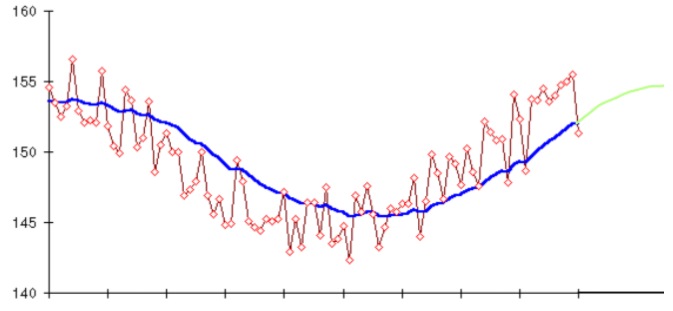

EWM: Provide exponential weighted (EW) functions.   
Ref: EWM in Time Series: https://medium.com/@parkashsharma/time-series-analysis-in-python-4f2e7a453ded

In [22]:
from scipy import optimize


def calc_shifted_ewm(series, alpha, adjust=True):
    return series.shift().ewm(alpha=alpha, adjust=adjust).mean()


def find_best_signal(series, adjust=False, eps=10e-5):
    
    def f(alpha):
        shifted_ewm = calc_shifted_ewm(series=series, alpha=min(max(alpha, 0), 1), adjust=adjust)
        corr = np.mean(np.power(series - shifted_ewm, 2))
        return corr
     
    res = optimize.differential_evolution(func=f, bounds=[(0 + eps, 1 - eps)])
    
    return calc_shifted_ewm(series=series, alpha=res['x'][0], adjust=adjust)

In [23]:
data.index = data['visit_date']

group the data with the `day_of_week` to optimize how Monday, Tuesday, Wednesday, ... affect the time series

In [24]:
roll = data.groupby(['air_store_id', 'day_of_week']).apply(lambda g: find_best_signal(g['visitors_capped']))

data['optimized_ewm_by_air_store_id_&_day_of_week'] = roll.sort_index(level=['air_store_id', 'visit_date']).values


data.head()

air_store_id  ... optimized_ewm_by_air_store_id_&_day_of_week
visit_date                        ...                                            
2016-07-01  air_00a91d42b08b08d9  ...                                         NaN
2016-07-02  air_00a91d42b08b08d9  ...                                         NaN
2016-07-03  air_00a91d42b08b08d9  ...                                         NaN
2016-07-04  air_00a91d42b08b08d9  ...                                         NaN
2016-07-05  air_00a91d42b08b08d9  ...                                         NaN

[5 rows x 28 columns]

Also apply `is_weekend`, `day_of_week`, and take log of them.

In [25]:
roll = data.groupby(['air_store_id', 'is_weekend']).apply(lambda g: find_best_signal(g['visitors_capped']))
data['optimized_ewm_by_air_store_id_&_is_weekend'] = roll.sort_index(level=['air_store_id', 'visit_date']).values

roll = data.groupby(['air_store_id', 'day_of_week']).apply(lambda g: find_best_signal(g['visitors_capped_log1p']))
data['optimized_ewm_log1p_by_air_store_id_&_day_of_week'] = roll.sort_index(level=['air_store_id', 'visit_date']).values

roll = data.groupby(['air_store_id', 'is_weekend']).apply(lambda g: find_best_signal(g['visitors_capped_log1p']))
data['optimized_ewm_log1p_by_air_store_id_&_is_weekend'] = roll.sort_index(level=['air_store_id', 'visit_date']).values

In [26]:
data.head()

air_store_id  ... optimized_ewm_log1p_by_air_store_id_&_is_weekend
visit_date                        ...                                                 
2016-07-01  air_00a91d42b08b08d9  ...                                              NaN
2016-07-02  air_00a91d42b08b08d9  ...                                              NaN
2016-07-03  air_00a91d42b08b08d9  ...                                         2.302585
2016-07-04  air_00a91d42b08b08d9  ...                                         3.583519
2016-07-05  air_00a91d42b08b08d9  ...                                         3.429266

[5 rows x 31 columns]

In [27]:
data.columns.values

array(['air_store_id', 'visit_date', 'visitors', 'was_na', 'is_test',
       'test_number', 'day_of_week', 'is_holiday', 'prev_day_is_holiday',
       'next_day_is_holiday', 'air_genre_name', 'air_area_name',
       'latitude', 'longitude', 'latitude_str', 'longitude_str',
       'station_id', 'station_latitude', 'station_longitude',
       'station_vincenty', 'station_great_circle', 'total_r_in_area',
       'is_weekend', 'day_of_month', 'is_outlier', 'visitors_capped',
       'visitors_capped_log1p',
       'optimized_ewm_by_air_store_id_&_day_of_week',
       'optimized_ewm_by_air_store_id_&_is_weekend',
       'optimized_ewm_log1p_by_air_store_id_&_day_of_week',
       'optimized_ewm_log1p_by_air_store_id_&_is_weekend'], dtype=object)

Okay, now we got the optimized columns.

### (3) Additional Features with Mean, Median, Standard Deviation, Minimum, Maximum, including EWM

The distribution reflects trends describing **how far the data are from the central value**, including statistics such as maximum, minimum, standard deviation, coefficient of variation, range and interquartile range. The shape of the distribution reflects whether the distribution is symmetrical, the degree of skewness and the flatness of the distribution, including statistics such as skewness and kurtosis.   

REF: https://bmcmedinformdecismak.biomedcentral.com/articles/10.1186/s12911-020-1063-x 

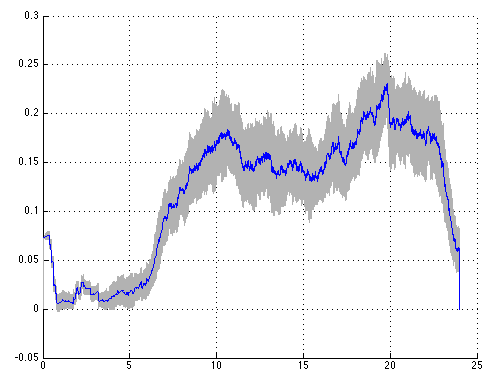

ValueError: 'visit_date' is both an index level and a column label, which is ambiguous.

In [28]:
data.index.name = None

In [29]:
def extract_precedent_statistics(df, on, group_by):
    
    df.sort_values(group_by + ['visit_date'], inplace=True)
    
    groups = df.groupby(group_by, sort=False)
    
    stats = {
        'mean': [],
        'median': [],
        'std': [],
        'count': [],
        'max': [],
        'min': []
    }
    
    exp_alphas = [0.1, 0.25, 0.3, 0.5, 0.75]
    stats.update({'exp_{}_mean'.format(alpha): [] for alpha in exp_alphas})
    
    for _, group in groups:
        
        shift = group[on].shift()
        roll = shift.rolling(window=len(group), min_periods=1)
        
        stats['mean'].extend(roll.mean())
        stats['median'].extend(roll.median())
        stats['std'].extend(roll.std())
        stats['count'].extend(roll.count())
        stats['max'].extend(roll.max())
        stats['min'].extend(roll.min())
        
        for alpha in exp_alphas:
            exp = shift.ewm(alpha=alpha, adjust=False)
            stats['exp_{}_mean'.format(alpha)].extend(exp.mean())
    
    suffix = '_&_'.join(group_by)
    
    for stat_name, values in stats.items():
        df['{}_{}_by_{}'.format(on, stat_name, suffix)] = values


extract_precedent_statistics(
    df=data,
    on='visitors_capped',
    group_by=['air_store_id', 'day_of_week']
)

extract_precedent_statistics(
    df=data,
    on='visitors_capped',
    group_by=['air_store_id', 'is_weekend']
)

extract_precedent_statistics(
    df=data,
    on='visitors_capped',
    group_by=['air_store_id']
)

extract_precedent_statistics(
    df=data,
    on='visitors_capped_log1p',
    group_by=['air_store_id', 'day_of_week']
)

extract_precedent_statistics(
    df=data,
    on='visitors_capped_log1p',
    group_by=['air_store_id', 'is_weekend']
)

extract_precedent_statistics(
    df=data,
    on='visitors_capped_log1p',
    group_by=['air_store_id']
)

data.sort_values(['air_store_id', 'visit_date']).head()

air_store_id  ... visitors_capped_log1p_exp_0.75_mean_by_air_store_id
2016-07-01  air_00a91d42b08b08d9  ...                                                NaN 
2016-07-02  air_00a91d42b08b08d9  ...                                           3.583519 
2016-07-03  air_00a91d42b08b08d9  ...                                           2.622819 
2016-07-04  air_00a91d42b08b08d9  ...                                           0.655705 
2016-07-05  air_00a91d42b08b08d9  ...                                           2.447318 

[5 rows x 97 columns]

### (5) Split Train and Test dataset

Things we need to do:   
- drop a few useless columns
- We predict the **log** of visitors above with EWM, and to get back to the original magnitude, we need to apply the exponential function to the prediction. **( $exp(log(x)) = x$)**

In [32]:
data['visitors_log1p'] = np.log1p(data['visitors'])
train = data[(data['is_test'] == False) & (data['is_outlier'] == False) & (data['was_na'] == False)]
test = data[data['is_test']].sort_values('test_number')

to_drop = ['air_store_id', 'is_test', 'test_number', 'visit_date', 'was_na',
           'is_outlier', 'visitors_capped', 'visitors', 'air_area_name',
           'station_id', 'station_latitude', 'station_longitude', 'station_vincenty',
           'station_great_circle', 'visitors_capped_log1p']
train = train.drop(to_drop, axis='columns')
train = train.dropna()
test = test.drop(to_drop, axis='columns')

X_train = train.drop('visitors_log1p', axis='columns')
X_test = test.drop('visitors_log1p', axis='columns')
y_train = train['visitors_log1p']


In [33]:
pd.to_datetime(train.index, format= '%Y-%m-%d')

DatetimeIndex(['2016-07-15', '2016-07-16', '2016-07-17', '2016-07-18',
               '2016-07-19', '2016-07-20', '2016-07-21', '2016-07-22',
               '2016-07-23', '2016-07-24',
               ...
               '2017-04-13', '2017-04-14', '2017-04-15', '2017-04-16',
               '2017-04-17', '2017-04-18', '2017-04-19', '2017-04-20',
               '2017-04-21', '2017-04-22'],
              dtype='datetime64[ns]', length=280032, freq=None)

In [34]:
train.head()

is_holiday  ...  visitors_log1p
2016-07-15           0  ...        3.367296
2016-07-16           0  ...        1.791759
2016-07-17           0  ...        0.000000
2016-07-18           1  ...        0.000000
2016-07-19           0  ...        3.258097

[5 rows x 102 columns]

### (6) Validation Set

Though I did not use this in the end, but at first, I tried to grab the validation set by devide the dataset based on the date 2017/3/30.   
But later, I decided to use **KFold** model selection method.    

The code is located in the section "Model - Train & Validaion" below.

In [ ]:
# getting train & validation indexes
train_index = train.loc[pd.to_datetime(train.index, format= '%Y-%m-%d') <= pd.to_datetime('2017-03-30',format= '%Y-%m-%d')].index
val_index = train.loc[pd.to_datetime(train.index, format= '%Y-%m-%d') > pd.to_datetime('2017-03-30',format= '%Y-%m-%d')].index
y = train['visitors_log1p'].values

In [35]:
X_train.head()

is_holiday  ...  air_genre_name_Yakiniku/Korean food
2016-07-15           0  ...                                    0
2016-07-16           0  ...                                    0
2016-07-17           0  ...                                    0
2016-07-18           1  ...                                    0
2016-07-19           0  ...                                    0

[5 rows x 101 columns]

In [36]:
X_train.index

DatetimeIndex(['2016-07-15', '2016-07-16', '2016-07-17', '2016-07-18',
               '2016-07-19', '2016-07-20', '2016-07-21', '2016-07-22',
               '2016-07-23', '2016-07-24',
               ...
               '2017-04-13', '2017-04-14', '2017-04-15', '2017-04-16',
               '2017-04-17', '2017-04-18', '2017-04-19', '2017-04-20',
               '2017-04-21', '2017-04-22'],
              dtype='datetime64[ns]', length=280032, freq=None)

In [39]:
sum(test[test["visitors_log1p"] == np.nan].count())

0

In [46]:
assert X_train.isnull().sum().sum() == 0
assert y_train.isnull().sum() == 0
assert len(X_train) == len(y_train)
assert X_test.isnull().sum().sum() == 0
assert len(X_test) == 32019

In [38]:
print(X_train.isnull().sum().sum())
print(y_train.isnull().sum())
print()

0
0



### Handle Categorical variables

There are many ways to handle categorical variables, and I tried 2 methods that are most widely used: **One-hot encodiing** and **Label encoding**   

#### When to use a Label Encoding vs. One Hot Encoding
- One-Hot Encoding when:
  - The categorical feature is not ordinal 
  - The number of categorical features is less so one-hot encoding can be effectively applied

- Label Encoding when:
  - The categorical feature is ordinal (like Jr. kg, Sr. kg, Primary school, high school)
  - The number of categories is quite large as one-hot encoding can lead to high memory consumption


REF: https://www.analyticsvidhya.com/blog/2020/03/one-hot-encoding-vs-label-encoding-using-scikit-learn/

### (7) One - Hot Encoding

Also Let's apply one-hot encode those **categorical variables**: ['day_of_week', 'air_genre_name' using **get_dummies** function.

In [30]:
data = pd.get_dummies(data, columns=['day_of_week', 'air_genre_name'])


### (8) Label encoding categorial features

Tried this label encoding, but did not include them on the dataset

In [40]:
from sklearn import preprocessing

train_opt = train.copy()
test_opt = test.copy()
text_columns = []
# label encoding categorical features
for f in train_opt.columns:
    if (train_opt[f].dtype == 'object'):  
        text_columns.append(f)            
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(train_opt[f].values) + list(test_opt[f].values))
        train_opt[f] = lbl.transform(list(train_opt[f].values))
        test_opt[f] = lbl.transform(list(test_opt[f].values))

Finally! We can generate the validation dataset.   
Personally, this was the hardest part overall.    

I found an important fact about `.iloc` and `.loc`: From Pandas documentation on `.iloc`:   
Pandas provides a suite of methods in order to get purely integer based indexing. The semantics follow closely python and numpy slicing. **These are 0-based indexing.**

In [ ]:
# Took too much time to grab the validation set... decided to skip this process
# validation data
val_train = train_opt.iloc[train_index]
val_train_y = y[train_index]
val_test = train_opt.iloc[val_index]
val_test_y = y[val_index]

val_train.to_csv(dest_path + 'val_train.csv',index=False)
val_test.to_csv(dest_path + 'val_test.csv',index=False)
np.save(dest_path + 'val_train_y.npy',val_train_y)
np.save(dest_path + 'val_test_y.npy',val_test_y)

### (9) Feature Importance

Check feature importance with XGBregressor

In [48]:
# ValueError: DataFrame.dtypes for data must be int, float or bool.
#                Did not expect the data types in fields latitude_str, longitude_str
to_drop = ['latitude_str', 'longitude_str']

X_train = X_train.drop(to_drop, axis='columns')
X_test= X_test.drop(to_drop, axis='columns')

In [49]:
import xgboost as xgb

# model
model = xgb.XGBRegressor()

model.fit(X=X_train, y = y_train)

[14:47:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [ ]:
feature_importances.sort_values(0, ascending=False)


In [ ]:
plt.figure(figsize=(15,12))
plt.title('Feature Importances (Top 20 features)')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')

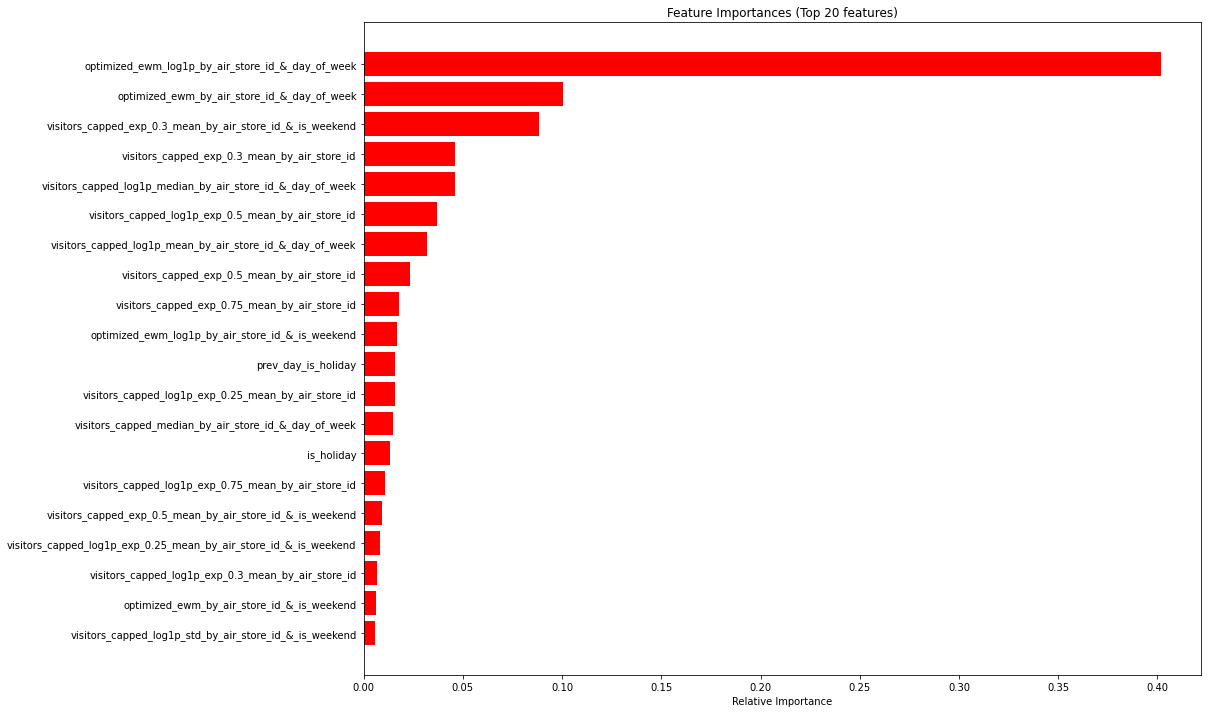

In [102]:
import matplotlib.pyplot as plt

features = X_train_2.columns
importances = model.feature_importances_
indices = (np.argsort(importances))[-20:]
plt.figure(figsize=(15,12))
plt.title('Feature Importances (Top 20 features)')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

###  (10) Feature Selection using Recursive Feature Elimination

We can find out optimal number of features to be selected using Recursive Feature Elimination Cross-Validation    
Feature selection is an important task for any machine learning application, and since we have a lot of features, we can reduce the number of features with this.


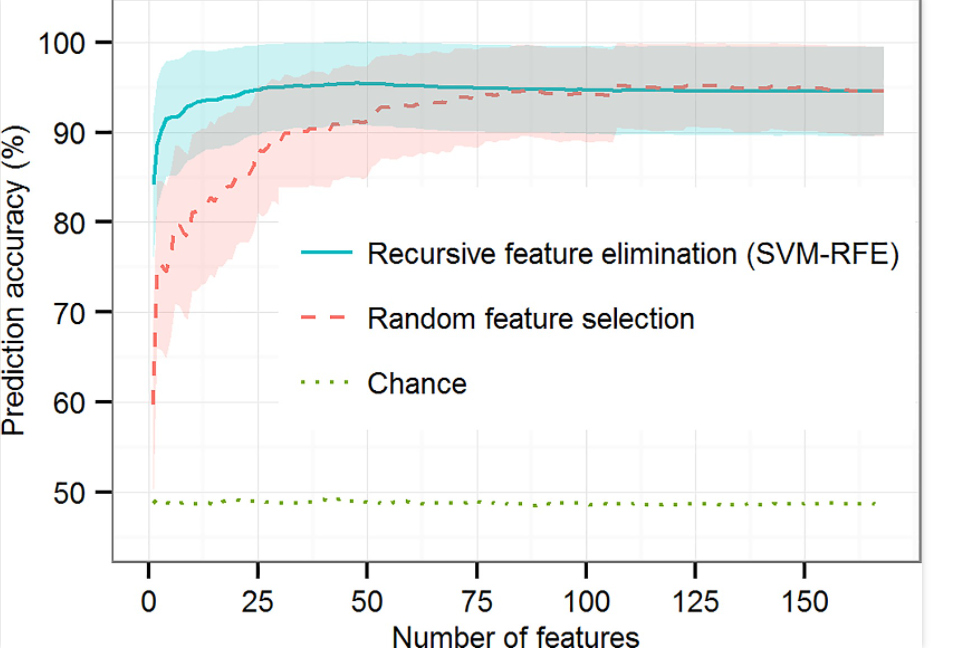

From the above picture, accuracy is shown for classifiers based on recursive feature elimination (solid blue line), random feature selection (dashed red line), and chance (dotted green line).  Shaded regions indicate mean ± 1 standard deviation over the 100 repetitions.   
REF: https://plos.figshare.com/articles/figure/Prediction_accuracy_as_a_function_of_the_numbers_of_features_selected_during_training_/4301102

I wondered what to choose between RFE and RFS (Random Feature Selection), but by looking at the graph, I think RFE will do the job here.

In [ ]:
# X_fit = X_train.iloc[model_s[0][0]]
# y_fit = y_train.iloc[model_s[0][0]]
# X_val = X_train.iloc[model_s[0][1]]
# y_val = y_train.iloc[model_s[0][1]]

In [126]:
# setting up Recursive Feature Eliminator with n_features_to_select=61
rfe = RFE(estimator=model, n_features_to_select=80)
rfe.fit(X_train,y_train)
print("Selected Columns and their respective ranks:-\n\n")
for i,j in enumerate(X_train.columns):
    if rfe.support_[i]:
        print('Column Name: {}, Rank: {}'.format(j, rfe.ranking_[i]))
    else:
        X_train.drop(columns=j,inplace=True)
        X_test.drop(columns=j,inplace=True)
        X_val.drop(columns=j,inplace=True)

Selected Columns and their respective ranks:-


Column Name: is_holiday, Rank: 1
Column Name: latitude, Rank: 1
Column Name: longitude, Rank: 1
Column Name: day_of_month, Rank: 1
Column Name: optimized_ewm_by_air_store_id_&_day_of_week, Rank: 1
Column Name: optimized_ewm_by_air_store_id_&_is_weekend, Rank: 1
Column Name: optimized_ewm_log1p_by_air_store_id_&_day_of_week, Rank: 1
Column Name: optimized_ewm_log1p_by_air_store_id_&_is_weekend, Rank: 1
Column Name: visitors_capped_std_by_air_store_id_&_day_of_week, Rank: 1
Column Name: visitors_capped_exp_0.1_mean_by_air_store_id_&_day_of_week, Rank: 1
Column Name: visitors_capped_exp_0.3_mean_by_air_store_id_&_day_of_week, Rank: 1
Column Name: visitors_capped_exp_0.75_mean_by_air_store_id_&_day_of_week, Rank: 1
Column Name: visitors_capped_mean_by_air_store_id_&_is_weekend, Rank: 1
Column Name: visitors_capped_std_by_air_store_id_&_is_weekend, Rank: 1
Column Name: visitors_capped_count_by_air_store_id_&_is_weekend, Rank: 1
Column Name: vi

In [120]:
X_train.shape, y_train.shape

((280032, 40), (280032,))

In [121]:
X_test.shape

(32019, 40)

In [113]:

# SAVING PROCESSED DATA AFTER RFE
X_train.to_csv(dest_path + 'X_train_after_RFE.csv',index=False)
X_val.to_csv(dest_path + 'X_val_after_RFE.csv',index=False)
X_test.to_csv(dest_path + 'X_test_after_RFE.csv',index=False)

### Summary of Feature Engineering

1. Apply the concept of '**resampling**' and '**rolling features**'
2. Handle Holidays & Weekend spike
3. Merge Train & Test (Submission) dataset by adding a column `is_test`
4. Merged `Air_store data, Air_visit data, date_info, and preprocessed weather data`
5. Grouping **genre-wise** and **area-wise** restaurants
6. Take care of **weekdays** and **day of month**
7. Tried multiple ways to create Validation set
8. Handle Categorical variables by trying **one-hot encoding** & **label encoding**
9. Visualize **Feature Importance**
10. Tried Feature Selection with **RFE (Recursive Feature Elimination)**

11. Handled outliers with taking log_1p
12. Optimization with **EWM (Exponential Weighted Average)**
13. Compute additional features with **mean, mediam, standard deviation, min, max**


# Model

## 1. Train & Validation

I will take the validation dataset from the train dataset using `KFold`. By using the `KFold`, I can shuffle the dataset and grab a partial data with the `random_state`.   

The label distribution of the dataset in each fold follows the label distribution of the entire dataset.

In other words, each fold is a good representation of the entire dataset, the model can be trained without bias.

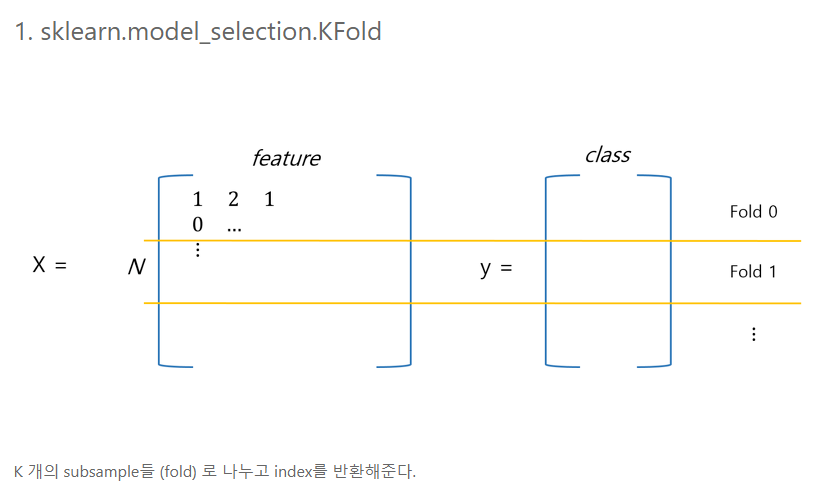

In [127]:
from sklearn import model_selection

cv = model_selection.KFold(n_splits=6, shuffle=True, random_state=42)
tmp = cv.split(X_train, y_train)
type(tmp)
model_s = list(tmp)
type(model_s)

res = submission['id'].to_frame()
res['visitors'] = 0


# validation dataset
X_fit = X_train.iloc[model_s[0][0]]
y_fit = y_train.iloc[model_s[0][0]]
X_val = X_train.iloc[model_s[0][1]]
y_val = y_train.iloc[model_s[0][1]]


Ref: https://sgmath.tistory.com/61

#### Lessons I learned here: Important, but easy to forget!
Since we are using `.iloc`, we need to careful about we want the return value as **dataframe, NOT a series**.  
I made a mistake on this and spent a good amount of time to see why the `.iloc` is returning only a single row of the data.

In [56]:
type(X_train_2)

pandas.core.frame.DataFrame

### 2. Create Model

1) lightGBM

2) GradientBoostingRegressor, KNeighborsRegressor, XGBRegressor 3가지 Regressor 앙상블

Kaggle에서 우수한 성적을 거둔 커널들을 참조한 결과, XGBoost와 lightGBM 모델을 사용했다는 것을 알 수 있었다.

모델을 충분히 테스트해 볼 시간이 부족한 관계로 '시간'을 기준으로 잡고, 1차적으로 모델을 필터링하여 선정하였다.

Model 1차 선정 결과, XGBoost의 느린 단점을 보완하여 탄생한 lightGBM을 사용하였다.

lightGBM의 하이퍼파라미터를 조정하여 총 두 번의 실험을 하였다.

### LGBM

조정 전: 15분   
조정 후: 10초   
score와 RMSLE결과값은 차이가 없었음.

In [123]:
import lightgbm as lgbm

model = lgbm.LGBMRegressor(
    objective='regression',
    max_depth=5,
    num_leaves=5 ** 2 - 1,
    learning_rate=0.2, # 조정 0.002 -> 0.2
    n_estimators=300, # 조정 300000 -> 300
    min_child_samples=80,
    subsample=0.8,
    colsample_bytree=1,
    reg_alpha=0,
    reg_lambda=0,
    random_state=np.random.randint(10e6)
)

model.fit(X_fit, y_fit, eval_set=[(X_fit, y_fit), (X_val, y_val)], eval_names=('fit', 'val'), eval_metric='l2', early_stopping_rounds=200, feature_name=X_fit.columns.tolist(), verbose=False
)


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1,
              importance_type='split', learning_rate=0.2, max_depth=5,
              min_child_samples=80, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=300, n_jobs=-1, num_leaves=24,
              objective='regression', random_state=2234489, reg_alpha=0,
              reg_lambda=0, silent=True, subsample=0.8,
              subsample_for_bin=200000, subsample_freq=0)

In [86]:
type(X_fit)

pandas.core.frame.DataFrame

lightGBM의 하이퍼파라미터를 다양하게 조정하여 실험을 더 많이 해 보았으면 좋았겠지만, 한정된 시간과 lightGBM은 하이퍼파라미터를 조정해도 결과값에 큰 변화가 없다는 자료, 두 가지 측면을 토대로 결정을 하여, lightGBM 모델은 2번의 실험으로 마무리하였다.

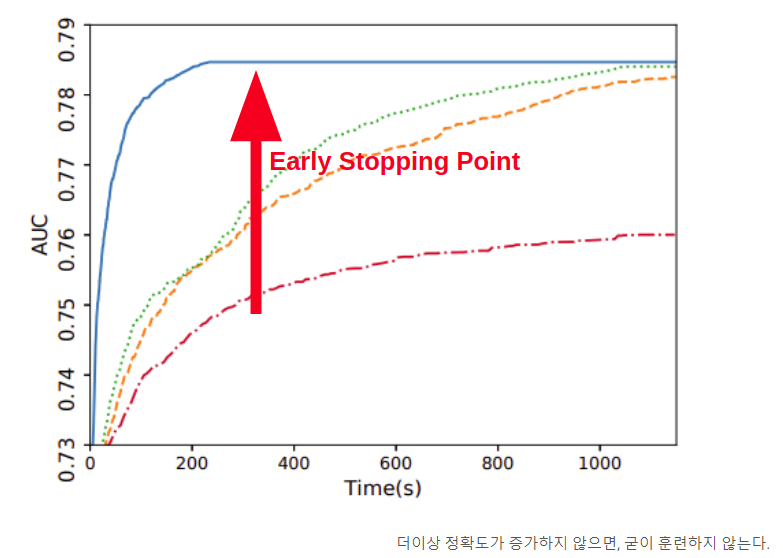

초반에 LGBM을 돌렸을 때, learning rate가 너무 낮아서 한번, early stopping point에 도달해서 모델이 두번 멈췄음.

REF: http://machinelearningkorea.com/2019/09/29/lightgbm-%ED%8C%8C%EB%9D%BC%EB%AF%B8%ED%84%B0/ 

Result 1: First attempt with no RFE

In [89]:
score = np.sqrt(model.best_score_['val']['l2']) # "12" means the default lgbm
res['visitors'] = model.predict(X_test, num_iteration=model.best_iteration_)
feature_importance = model.feature_importances_
print("RMLSE: ", score)

RMLSE:  0.7105582145767655


Result 2: Second attempt with REF 61

In [117]:
score = np.sqrt(model.best_score_['val']['l2']) 
res['visitors'] = model.predict(X_test, num_iteration=model.best_iteration_)
feature_importance = model.feature_importances_
print("RMLSE: ", score)

RMLSE:  0.7145042415471411


Result 3: Second attempt with REF 40

In [124]:
score = np.sqrt(model.best_score_['val']['l2']) 
res['visitors'] = model.predict(X_test, num_iteration=model.best_iteration_)
feature_importance = model.feature_importances_
print("RMLSE: ", score)

RMLSE:  0.7174194777064974


The score is getting higher...    
I think at this point I nned to try ensemble.

Export the result to a CSV file.

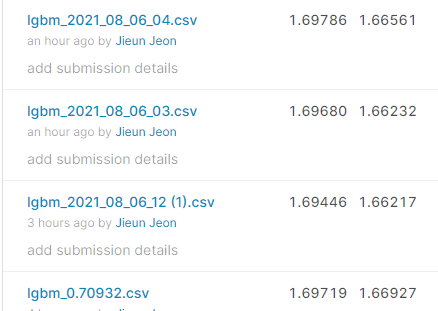

The score is way too high.
I will re-do the feature selection, then try other models if necessary.

Score 값이 너무 높게 나왔기 때문에, lightGBM 모델을 사용한 실험은 여기서 멈추고, 다른 방법을 고안했다.

In [125]:
res.to_csv(dest_path + '/lgbm_2021_08_06_04.csv', index=False)


### Ensemble

The multiple attemps with RFE did not improve the score.   
Now let's try ensembling multiple models with  GradientBoostingRegressor, KNeighborsRegressor, and XGBRegressor.

In [136]:
from sklearn import neighbors 
from xgboost import XGBRegressor
from sklearn import ensemble

col = [c for c in train if c not in ['id', 'air_store_id', 'visit_date','visitors']]

def RMSLE(y, pred):
    return metrics.mean_squared_error(y, pred)**0.5
    
model1 = ensemble.GradientBoostingRegressor(learning_rate=0.2, random_state=3, n_estimators=200, subsample=0.8, 
                      max_depth =10)
model2 = neighbors.KNeighborsRegressor(n_jobs=-1, n_neighbors=4)
model3 = XGBRegressor(learning_rate=0.2, random_state=3, n_estimators=280, subsample=0.8, 
                      colsample_bytree=0.8, max_depth =12)
#  X_fit, y_fit,
model1.fit(X_fit, y_fit,)
model2.fit(X_fit, y_fit,)
model3.fit(X_fit, y_fit,)

preds1 = model1.predict(X_fit)
preds2 = model2.predict(X_fit)
preds3 = model3.predict(X_fit)

print('RMSE GradientBoostingRegressor: ', RMSLE(y_fit, preds1))
print('RMSE KNeighborsRegressor: ', RMSLE(y_fit, preds2))
print('RMSE XGBRegressor: ', RMSLE(y_fit, preds3))

RMSE GradientBoostingRegressor:  0.4461286853261683 
RMSE KNeighborsRegressor:  0.6400569702970031 
RMSE XGBRegressor:  0.2621902068998613


Attempt 4: Ensemble with GradientBoostingRegressor, KNeighborsRegressor, and XGBRegressor

In [132]:
preds1 = model1.predict(X_test)
preds2 = model2.predict(X_test)
preds3 = model3.predict(X_test)

res['visitors'] = 0.3*preds1 + 0.3 * preds2 + 0.4*preds3
res['visitors'] = np.expm1(res['visitors']).clip(lower=0.)
sub1 = res[['id','visitors']].copy()
# del train; del data;

#### Bagging
Gradient Boosting Regressor

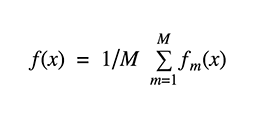

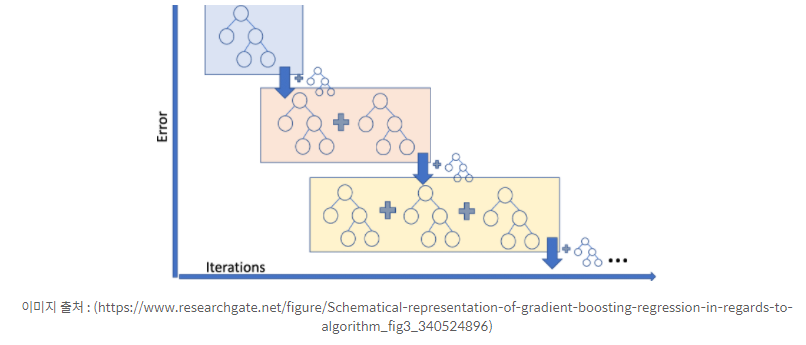

REF: https://biology-statistics-programming.tistory.com/49

In [133]:
sub1.to_csv(dest_path + '/lgbm_2021_08_06_04_ensemble.csv', index=False)


GradientBoostingRegressor, KNeighborsRegressor, XGBRegressor 3가지를 앙상블한 결과 0.5점대로 최적의 결과를 만들 수 있었다. Kaggle의 Discussion을 검토하였을 때, 앙상블 모델을 사용하면 가까운 미래의 방문자 수 예측은 가능하나 먼 미래의 방문자 수 예측은 어렵다는 의견이 있었다. 그런 측면을 알고 있었기 때문에 lightGBM을 사용하여 Score 값을 도출해 보려고 노력했으나, Score를 맞추기 위해 앙상블 모델을 사용하게 되었다.

## Result

Finally! We got the score of 0.58640

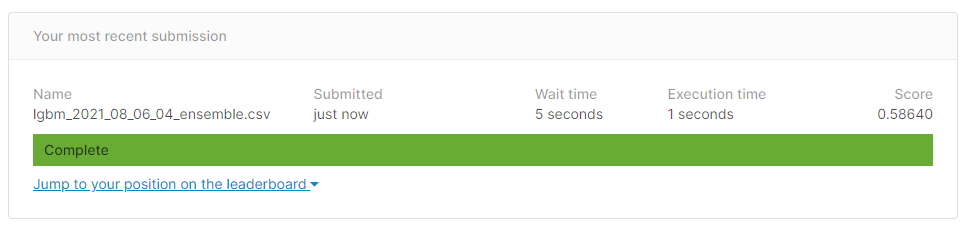

Now I can proudly say, ensemble is the game-changer.    


# References

Kernels
- Max HalFold: https://github.com/MaxHalford/kaggle-recruit-restaurant/blob/master/Solution.ipynb
- Got an idea of ensemble models: https://www.kaggle.com/tunguz/surprise-me-2
- Got an idea merging data with the mean values: https://www.kaggle.com/dongxu027/mean-mix-math-geo-harmonic-lb-0-493
- Got an insight of **Feature Engineering**: https://github.com/ligz08/Kaggle-Recruit-Restaurant-Visitor-Forecasting/blob/master/Feature_Engineering.ipynb 

Disucssion
- Externel weather dataset: https://www.kaggle.com/huntermcgushion/rrv-weather-data
- Q: How do you deal with outlier? A: Assuming that the number of visitors as a random variable with a normal distribution: https://www.kaggle.com/c/recruit-restaurant-visitor-forecasting/discussion/46939

Articles
- EWM: https://stackoverflow.com/questions/64575336/ewm-in-pandas-for-timeseries-transformation 
- Ideas of possible approaches: https://medium.com/analytics-vidhya/recruit-restaurant-visitor-forecasting-f9ef87ba1073